# Boston Housing Data

Available in ``MASS`` package. Response $Y$ = median value of owner-occupied homes in 1000's. There are $p = 13$ predictors and 506 samples in this dataset.

In [11]:
library(MASS)
library(gridExtra)
library(monomvn)
library(glmnet)
library(reshape2)
library(ggplot2)

data("Boston")

#-----------------------------------------------------------------------------
# some user-defined functions 

# plot marginal posterior density of beta
pos_dens_beta <- function(beta_MCMC, beta_RW1, beta_RW2, beta_RW3, title){
  df <- rbind(
    melt(beta_RW1)[,-1],
    melt(beta_RW2)[,-1],
    melt(beta_RW3)[,-1],
    melt(beta_MCMC)[,-1]
  )
  colnames(df) <- c("variable", "beta")
  method = c(
    rep("RW_scheme1",B*p),
    rep("RW_scheme2",B*p),
    rep("RW_scheme3",B*p),
    rep("MCMC",B*p)
  )
  df <- cbind(method, df)
  
  ggplot(df, aes(beta,colour = method)) +
    geom_density(alpha = 1) + 
    facet_wrap(~ variable,scales = "free",ncol = 2)+
    theme_bw() + 
    scale_color_manual(values = c("black", "red", "blue","green")) +
    labs(title = title) + 
    theme(plot.title = element_text(hjust = 0.5))
}

# plot marginal posterior cdf of beta
pos_cdf_beta <- function(beta_MCMC, beta_RW1, beta_RW2, beta_RW3, title){
  df <- rbind(
    melt(beta_RW1)[,-1],
    melt(beta_RW2)[,-1],
    melt(beta_RW3)[,-1],
    melt(beta_MCMC)[,-1]
  )
  colnames(df) <- c("variable", "beta")
  method = c(
    rep("RW_scheme1",B*p),
    rep("RW_scheme2",B*p),
    rep("RW_scheme3",B*p),
    rep("MCMC",B*p)
  )
  df <- cbind(method, df)
  
  ggplot(df, aes(beta,colour = method)) +
    stat_ecdf(geom = "step") + 
    facet_wrap(~ variable,scales = "free",ncol = 2)+
    theme_bw() + 
    scale_color_manual(values = c("black", "red", "blue","green")) +
    labs(title = title, y = "ecdf") + 
    theme(plot.title = element_text(hjust = 0.5))
}

# plot probability of variables being selected
plot_prob_var_select <- function(select_MCMC, select_RW1, select_RW2, select_RW3){
  prob_iii <- match( names( sort(select_MCMC, decreasing = T) ),
                     names( select_MCMC ) )
  
  plot(1:p, select_MCMC[prob_iii], type = "b", xaxt = "n", pch = 16, 
       ylab = "probability of variable being selected", main = "", xlab = "variables" )
  axis(side = 1, at = 1:p, labels = var_name[prob_iii])
  lines(1:p, select_RW1[prob_iii], type = "b", lty = 2, pch = 16, col = "red")
  lines(1:p, select_RW2[prob_iii], type = "b", lty = 3, pch = 16, col = "blue")
  lines(1:p, select_RW3[prob_iii], type = "b", lty = 4, pch = 16, col = "green")
  legend('bottomleft', bty = "n", lty = c(1:4), col = c("black", "red", "blue","green"),
         c("MCMC", "RW scheme 1", "RW scheme 2","RW scheme 3"))
}

# ggplot function for density or ecdf plot
dens_plot.func <- function(MCMC_vec, RW1_vec, RW2_vec, RW3_vec, xlab, title, plot_type){
  df <- data.frame(
    method = rep(c("MCMC", "RW_scheme1", "RW_scheme2", "RW_scheme3"), 
                 times = c(length(MCMC_vec), length(RW1_vec), length(RW2_vec), length(RW3_vec))),
    value = c(MCMC_vec, RW1_vec, RW2_vec, RW3_vec)
  )
  if(plot_type == "density"){
    ggplot(df, aes(x=value, color=method)) +
      geom_density() + 
      labs(x = xlab, title = title) +
      scale_color_manual(values = c("black", "red", "blue","green")) +
      theme(plot.title = element_text(hjust = 0.5))
  } else if(plot_type == "ecdf"){
    ggplot(df, aes(x=value, color=method)) +
      stat_ecdf(geom = "step") + 
      labs(x = xlab, title = title, y = "ecdf") +
      scale_color_manual(values = c("black", "red", "blue","green")) +
      theme(plot.title = element_text(hjust = 0.5))
  }
}

# Data Processing

We randomly split the samples into training set and test set in a ratio of 4:1. We then scale the predictors and responses in both training and test sets. We also verify that the predictor matrices of training and test sets are full-ranked. 

We will draw 2000 posterior samples from MCMC as well as from the random-weighting schemes. For MCMC, we specify a 2000 burn-in period. 

In [2]:
# First, randomly split training/validation and test set in ratio of 4:1

set.seed(1)
test_samp <- base::sample(1: nrow(Boston), size = ceiling(nrow(Boston)/5))
train_samp <- which( !(c(1: nrow(Boston)) %in% test_samp) )

Y = Boston$medv
X = subset(Boston, select = -c(medv))

Y_train = Y[train_samp]
X_train = X[train_samp,]
Y_test = Y[test_samp]
X_test = X[test_samp,]

# scale predictors and responses
Y_train = scale(Y_train)
X_train = scale(X_train)
Y_test = scale(Y_test)
X_test = scale(X_test)

n_train = nrow(X_train)
n_test = nrow(X_test)
p = ncol(X)
var_name = colnames(X)

rm(Y,X)

B = 2000
burn_in = 2000

SSTO_train <- sum( (Y_train - mean(Y_train))^2 )

# Bayesian Inference

We use ``blasso`` function in the R package ``monomvn`` to perform RJMCMC Bayesian Lasso inference. Denote number of selected variables as $k_n$. Then the hierarchical representation of the full model using default setting in ``blasso`` function is:

\begin{align*}
k_n &\sim {\rm DiscreteUnif} 
\left( 
\{ 1, \cdots, p \} \,\, {\rm w.p.} \,\,
\left\{\frac{1}{p}, \cdots, \frac{1}{p} \right\}  
\right) \\
\lambda^2 &\sim \text{Jeffrey's prior, coded as } \Gamma(r=0, \delta=0) \\
(\tau_1, \cdots, \tau_{k_n}) \big| k_n &\stackrel{iid}{\sim} \exp \left\{ \frac{\lambda^2}{2} \right\} \\
\sigma^2 &\sim \dfrac{1}{\sigma^2} \text{ non-informative prior} \\
\boldsymbol{\beta}_{k_n} \big| \left( \sigma^2, k_n, \tau_1, \cdots, \tau_{k_n} \right) &\sim
N_{k_n} \left( \boldsymbol{0} \, , \, \sigma^2 \boldsymbol{D}_{k_n} \right) 
\text{ for } \boldsymbol{D}_{k_n} = diag(\tau_1, \cdots, \tau_{k_n}) \\
\boldsymbol{Y} \big| \left(\mu, k_n, \boldsymbol{X}_{k_n}, \boldsymbol{\beta}_{k_n}, \sigma^2 \right)  
&\sim N_{k_n} \left( \mu \boldsymbol{1} + \boldsymbol{X}_{k_n} \boldsymbol{\beta}_{k_n} \, , \,  \sigma^2 I_{k_n} \right) 
\end{align*}

Conditional posterior of each parameters can be obtained via Gibbs sampling. Default setting of ``blasso`` function enables conditional posterior of $\sigma^2$ to be sampled after rao-blackwellization (integrating out $\boldsymbol{\beta}$). Intercept term $\mu$ is also fitted. 

In [27]:
set.seed(1)
blasso_fit <- blasso(X = X_train, y = Y_train, T = B + burn_in, verb = 0)
beta_MCMC <- blasso_fit$beta[(burn_in + 1) : (B + burn_in),]
colnames(beta_MCMC) <- var_name

# probability of variables being selected
select_MCMC <- apply(beta_MCMC, 2, function(x){
  1 - sum(as.numeric(x == 0))/B})

# SSE and R^2
SSE_MCMC <- apply(beta_MCMC, 1, function(b){
  sum( (Y_train - X_train %*% b)^2 )
})
R2_MCMC <- 1 - SSE_MCMC/SSTO_train

# MSPE
MSPE_MCMC <- apply(beta_MCMC, 1, function(b){
  mean( (Y_test - X_test %*% b)^2 )
})

We then check the trace plots to assess the MCMC chains.

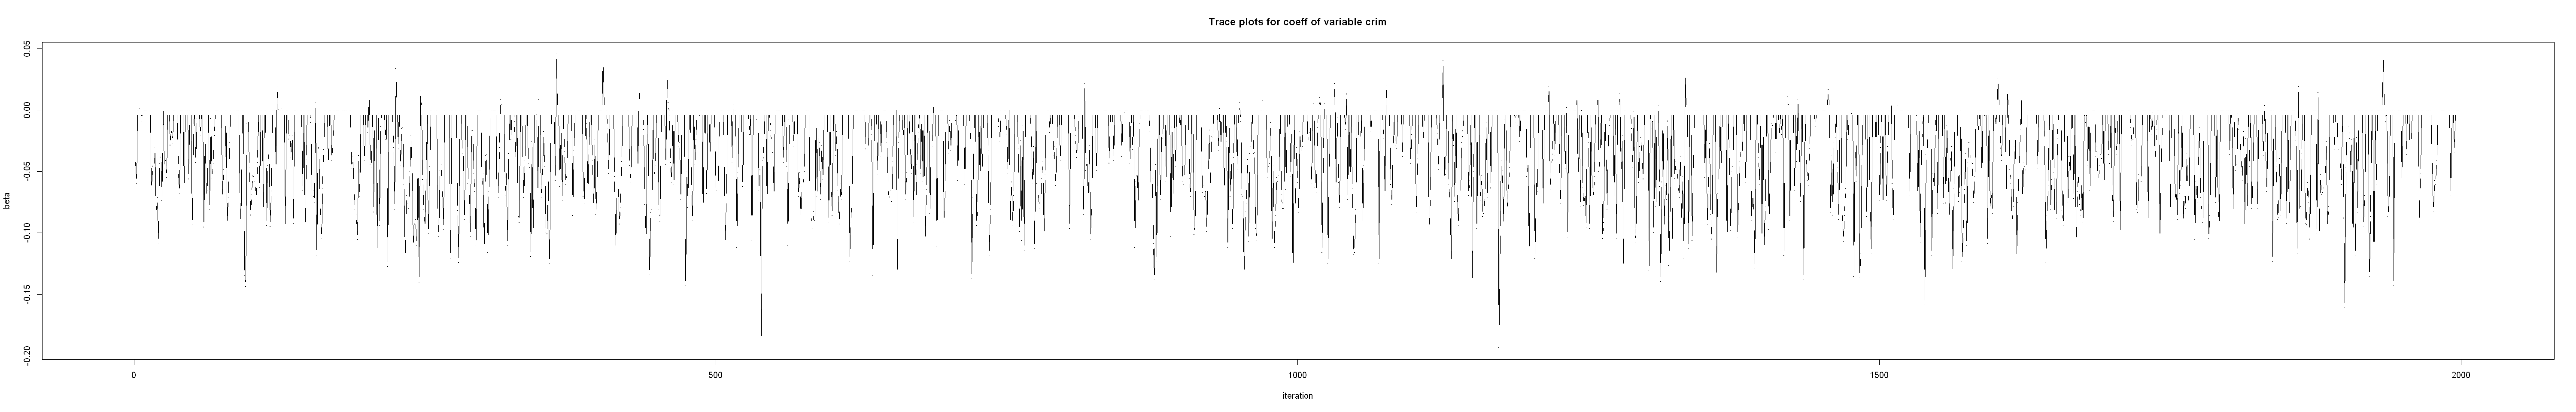

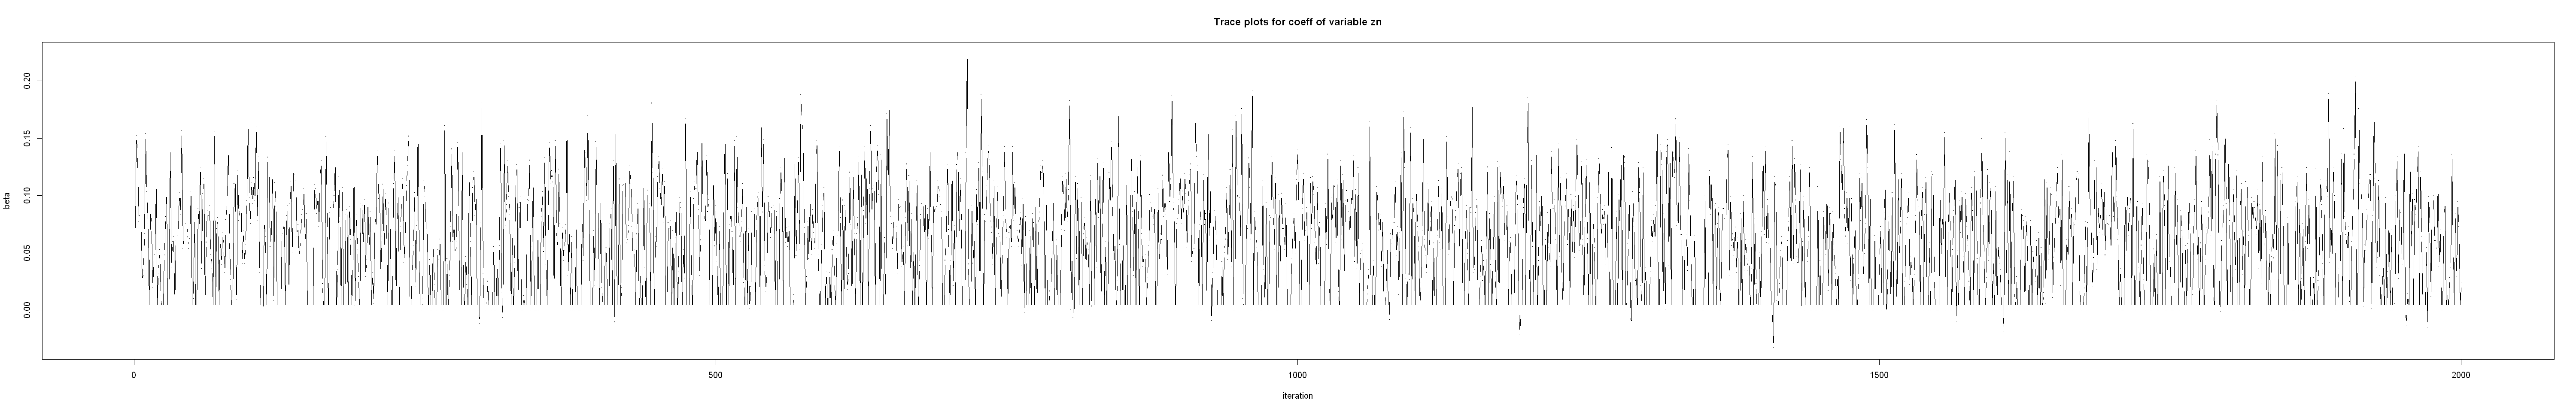

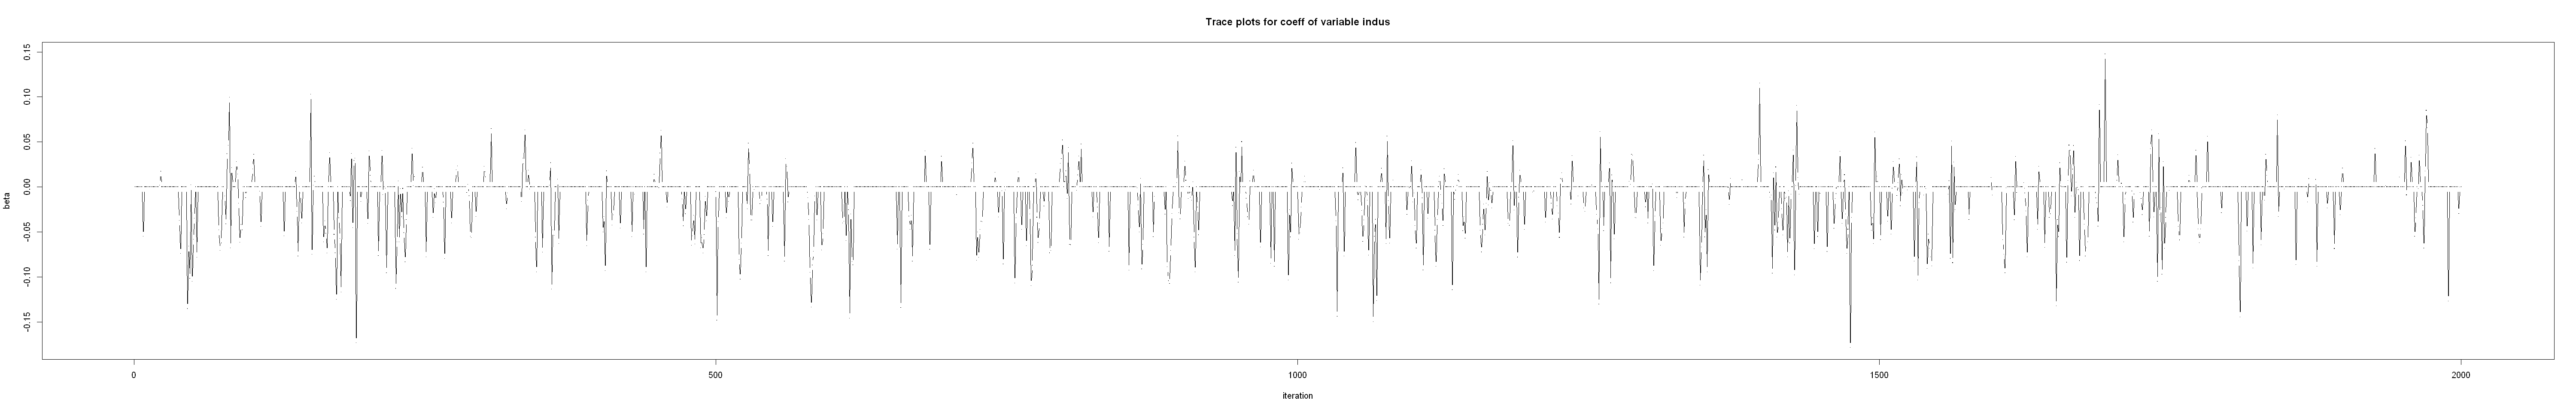

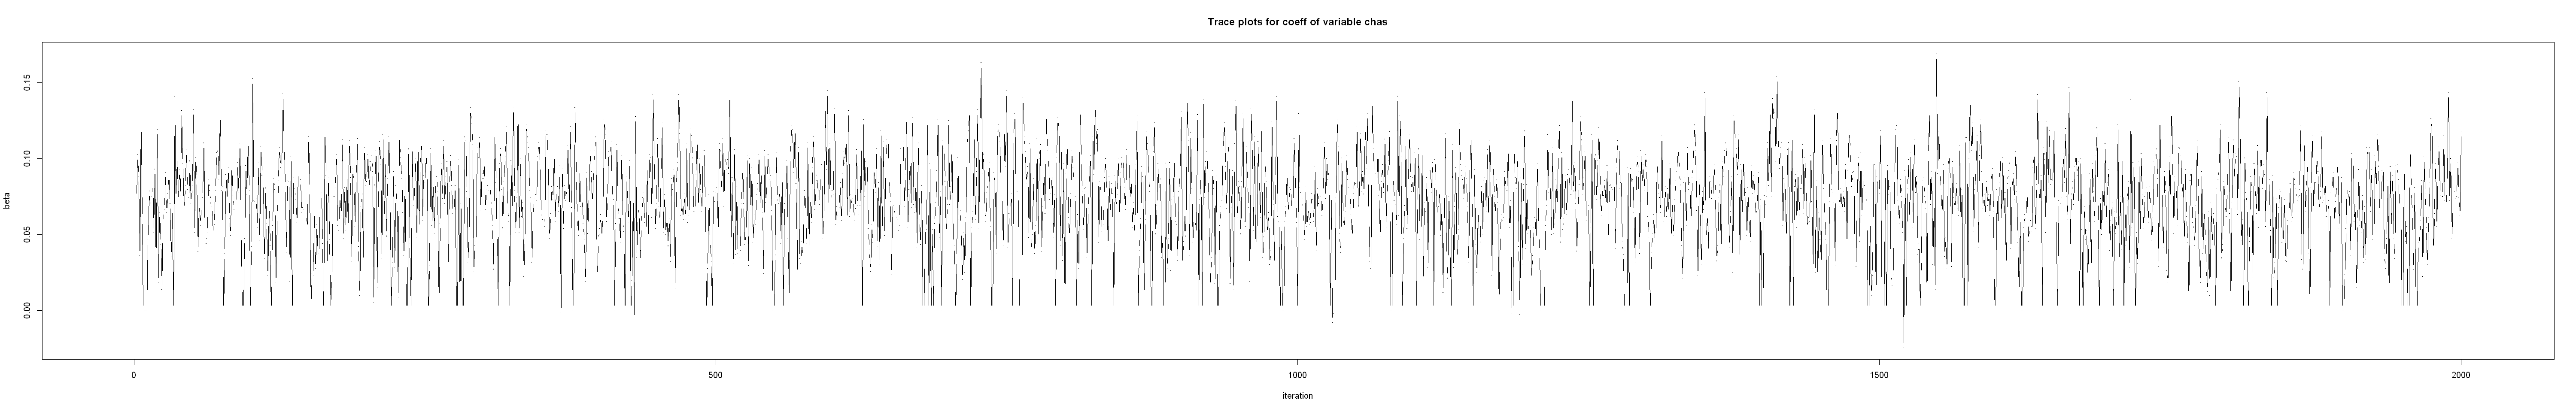

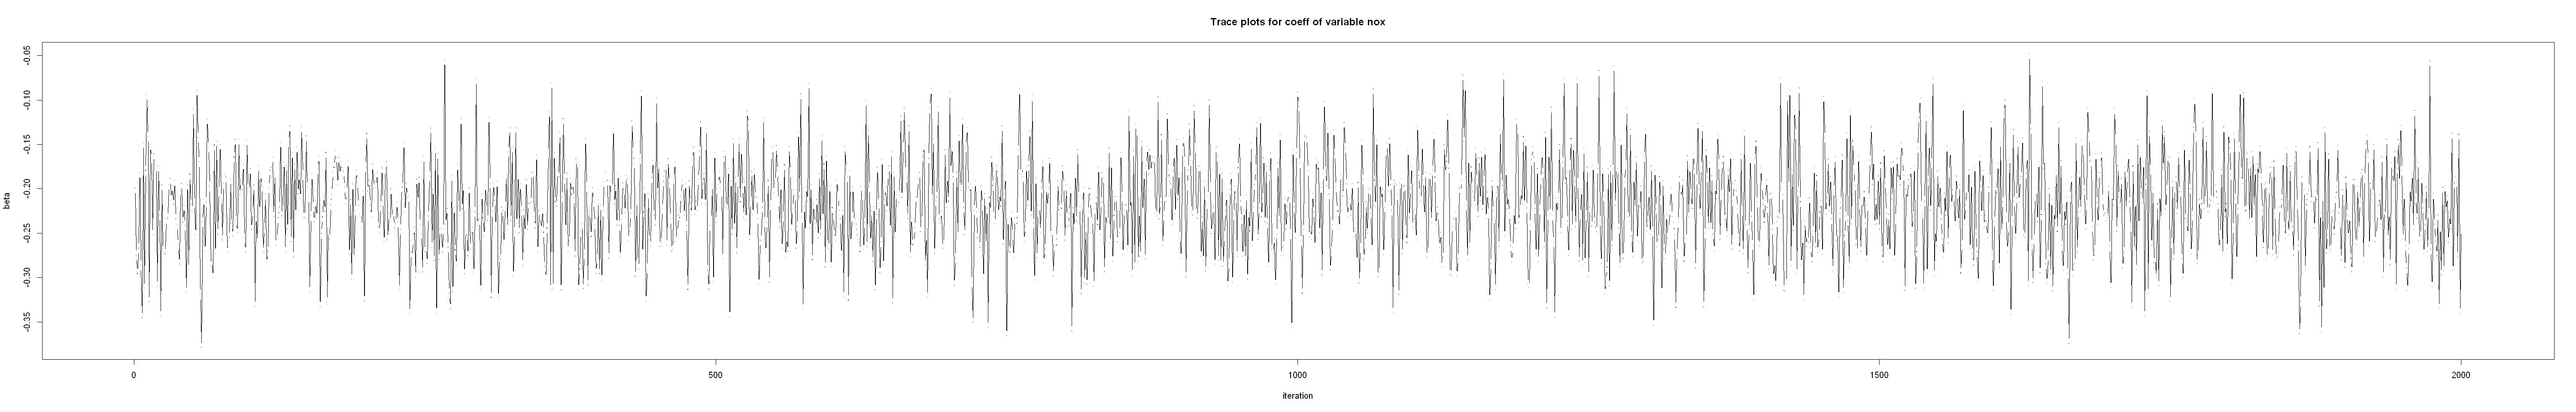

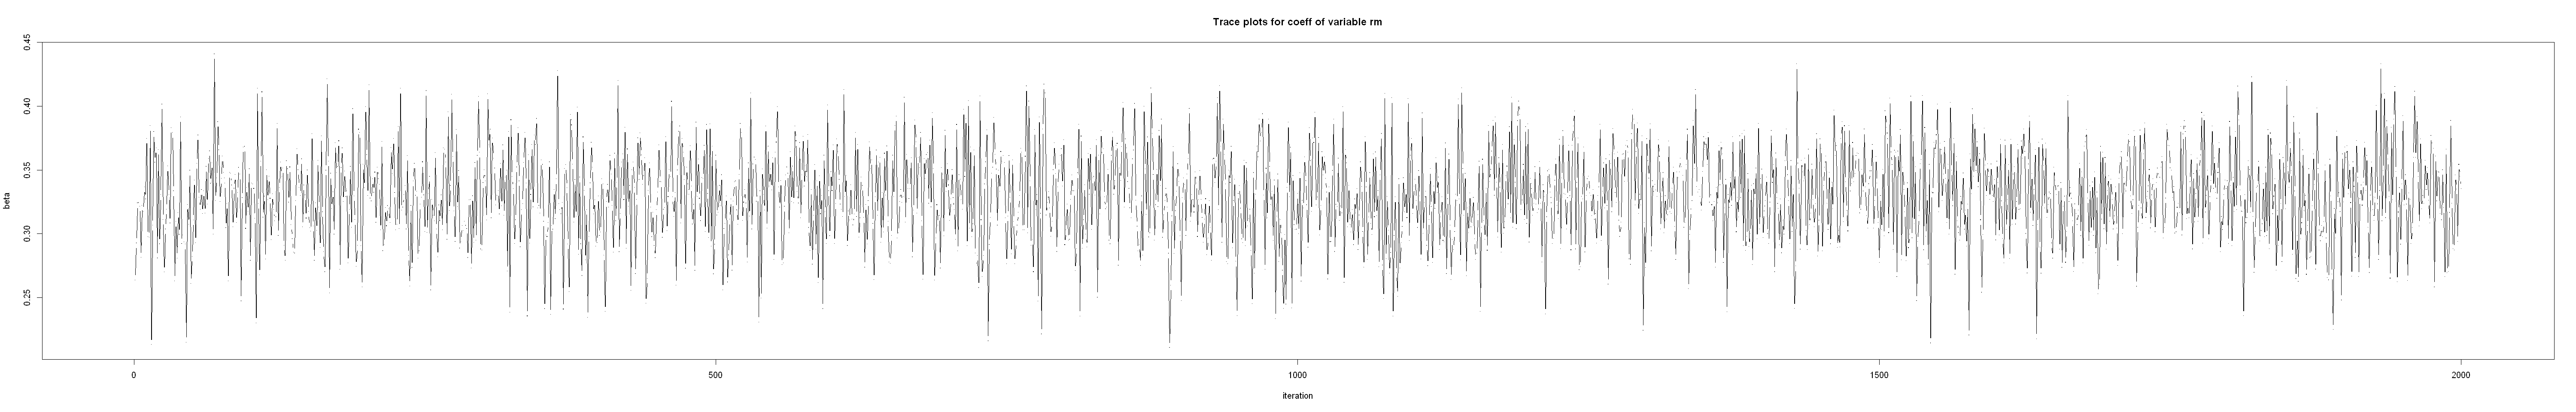

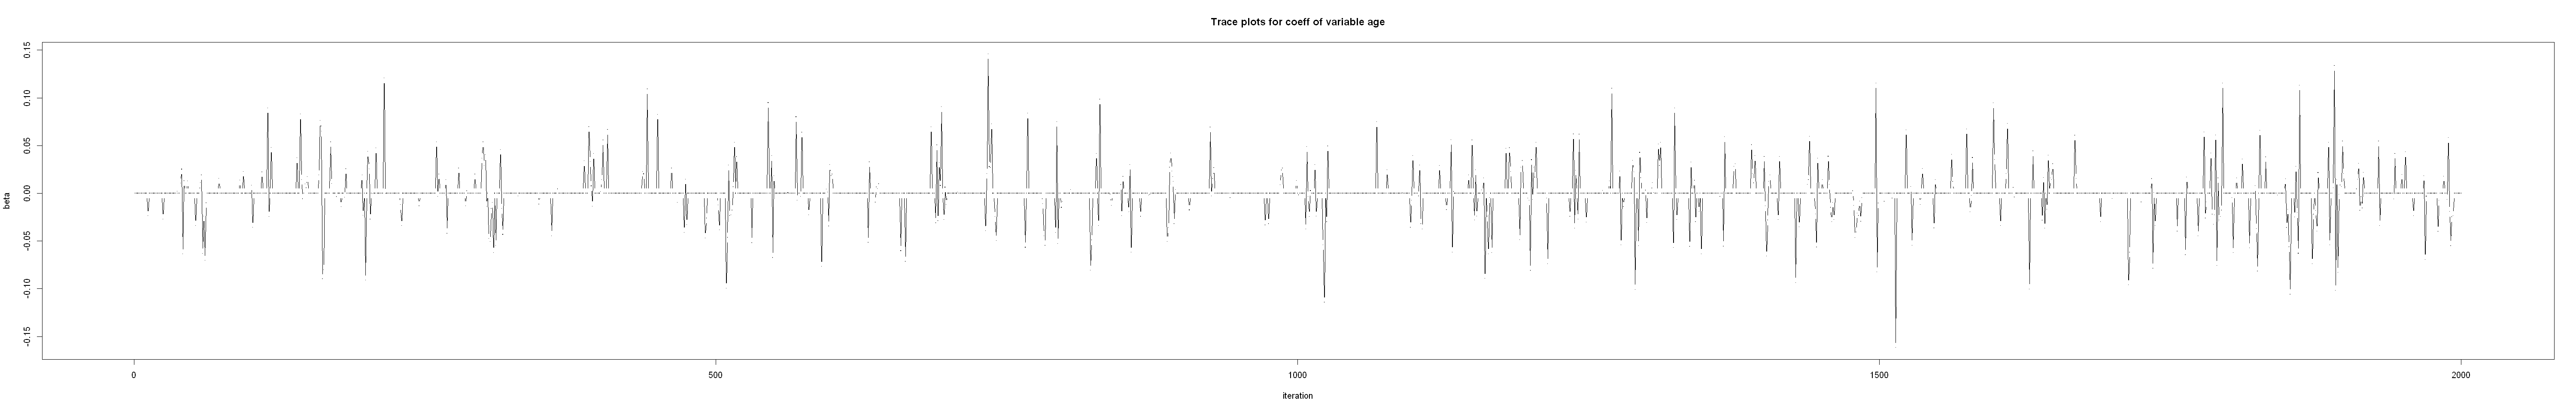

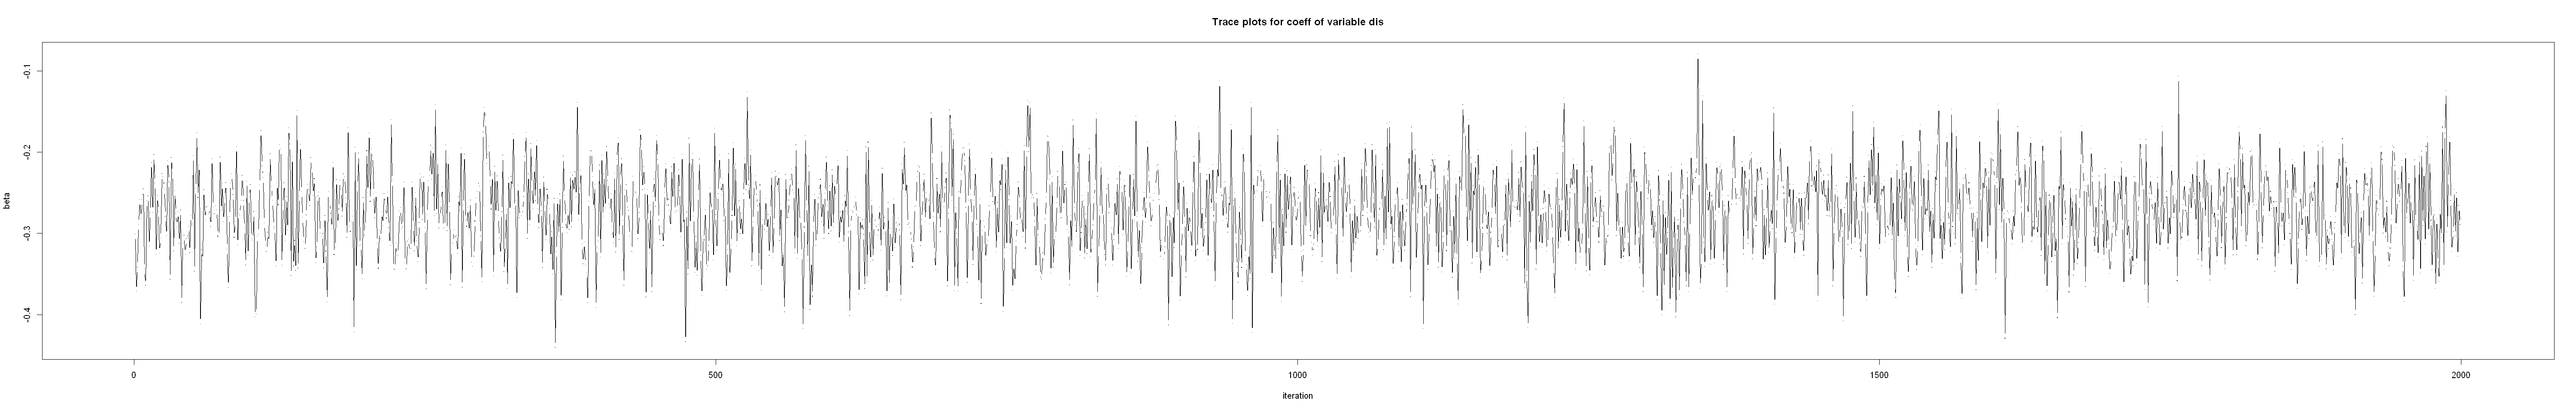

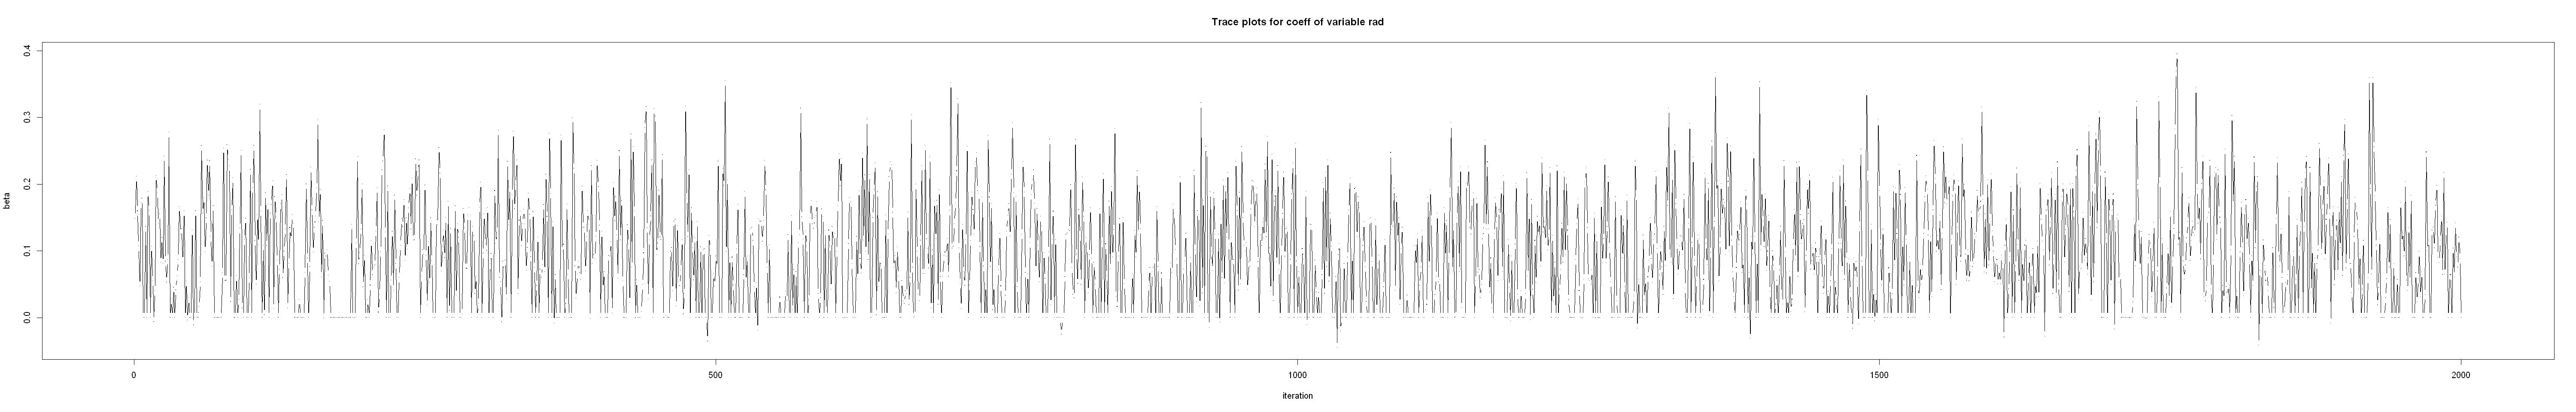

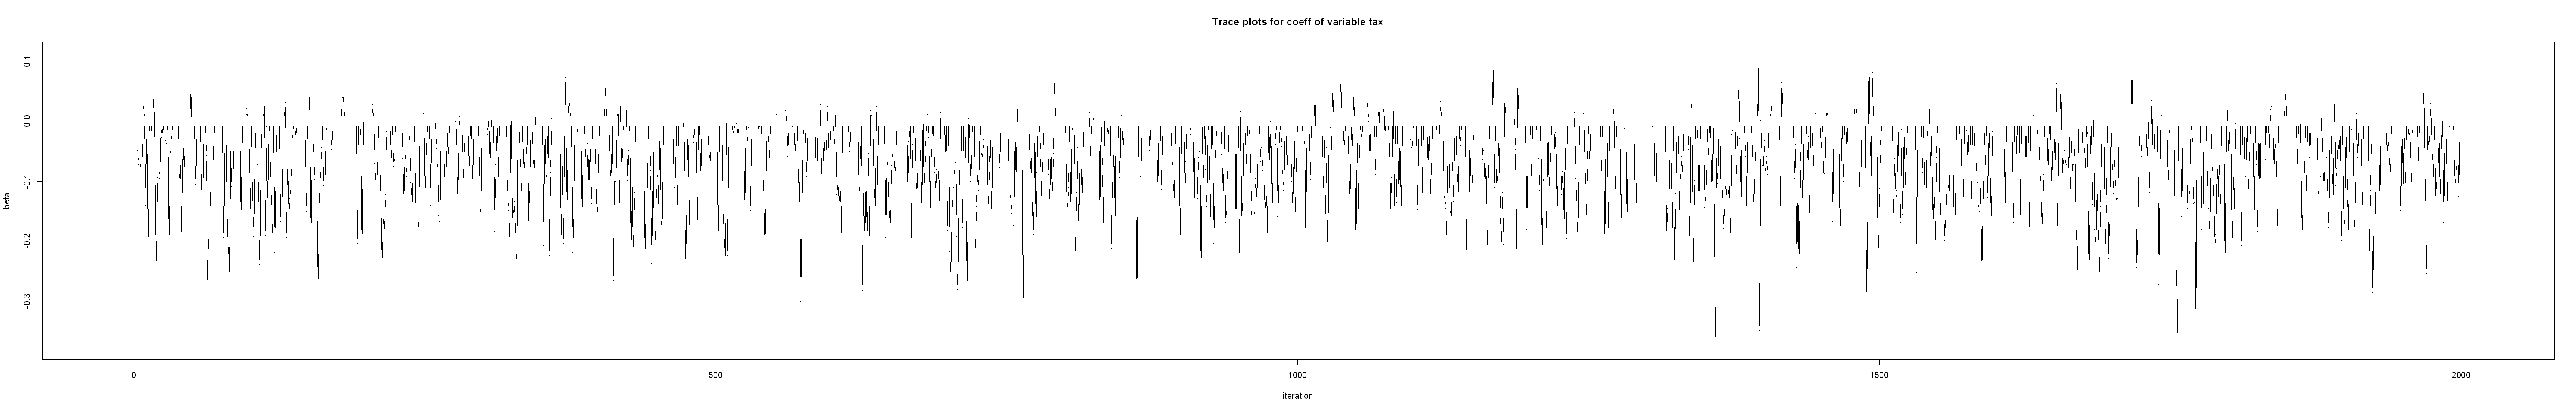

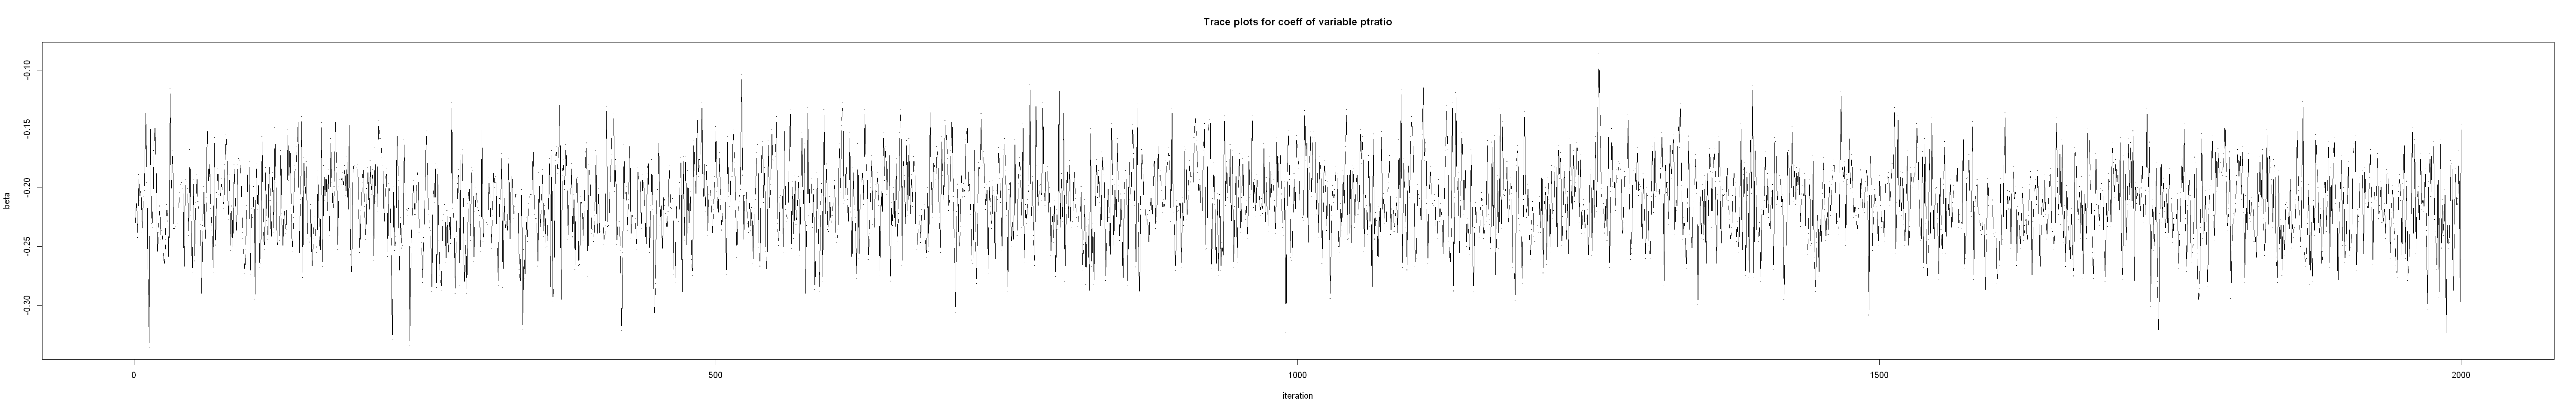

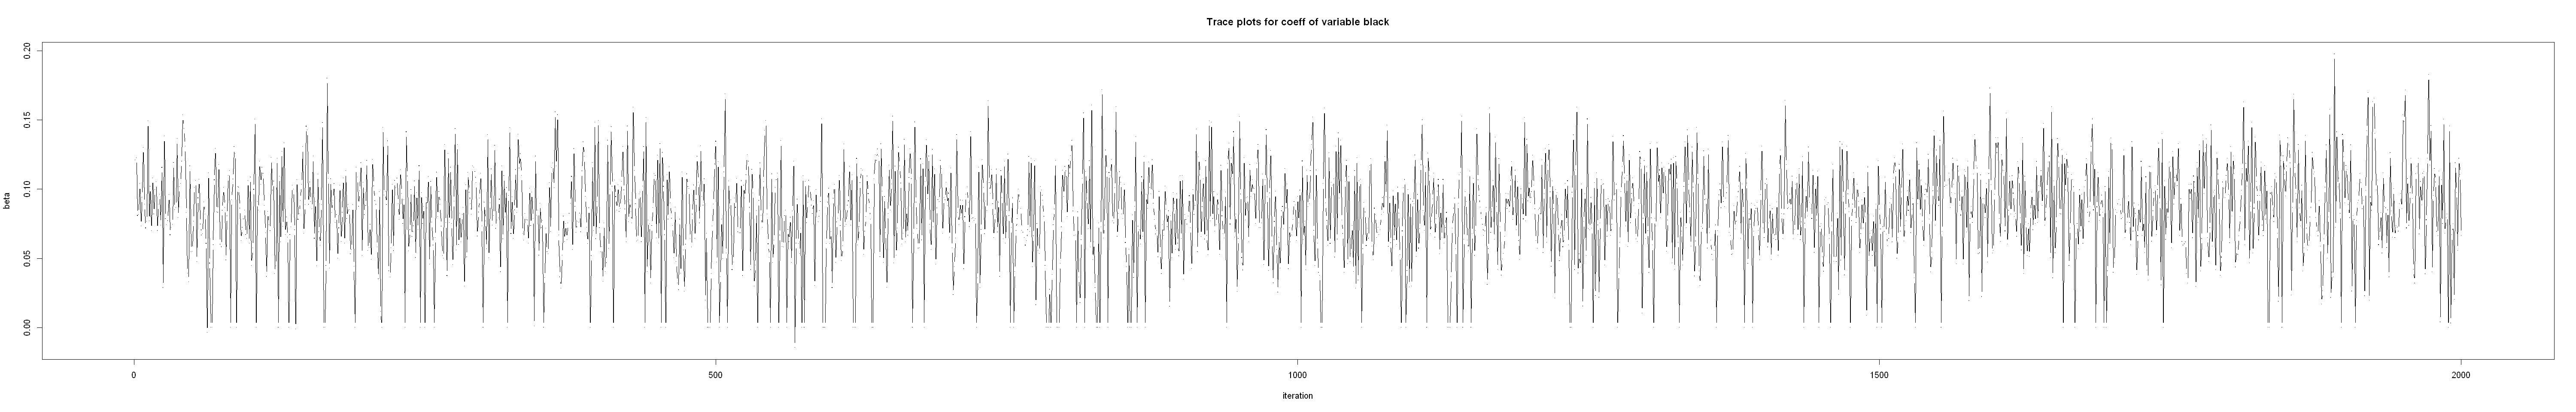

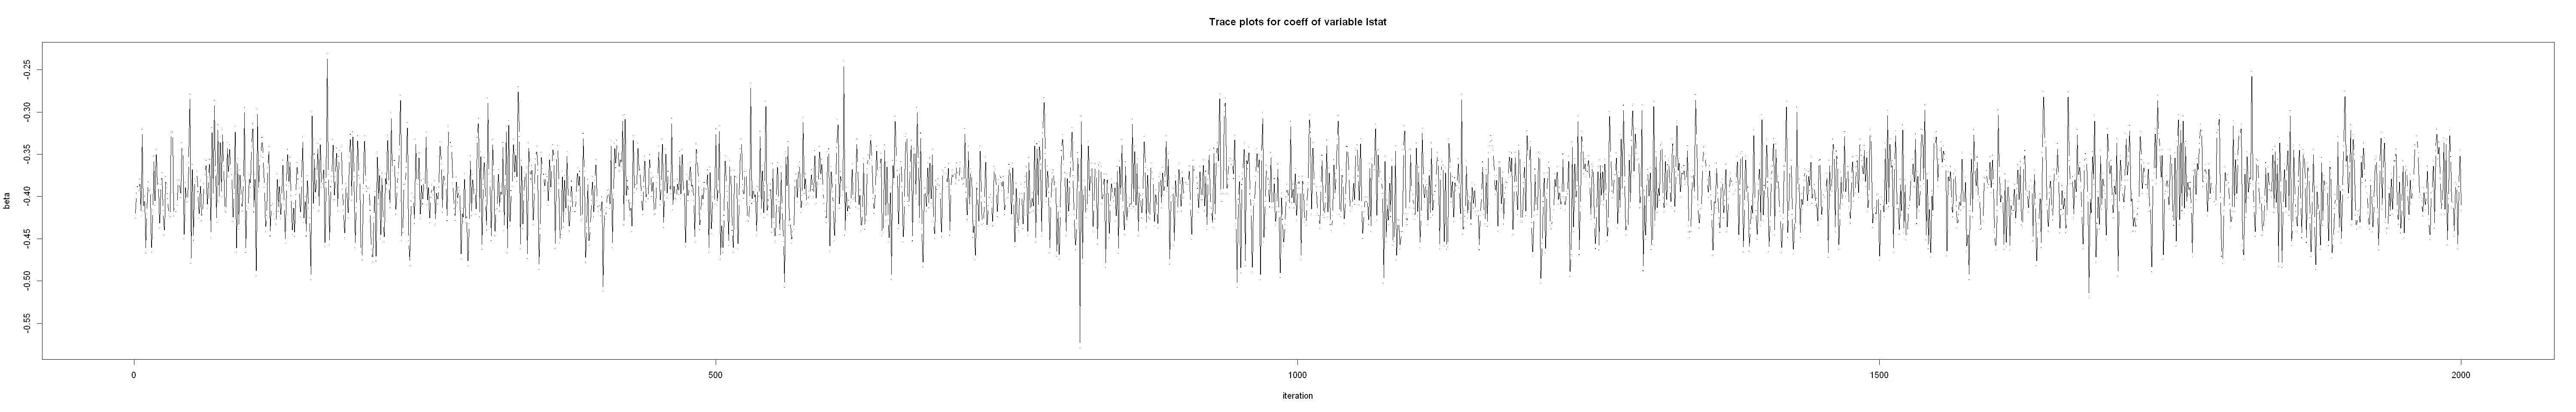

In [4]:
options(repr.plot.width = 50, repr.plot.height = 8)

# check trace plots of betas
for(j in 1:p){
  plot(1:B, beta_MCMC[,j], type = "b", pch = ".", xlab = "iteration",  ylab = "beta",
       main = paste0("Trace plots for coeff of variable ", colnames(beta_MCMC)[j]))
}

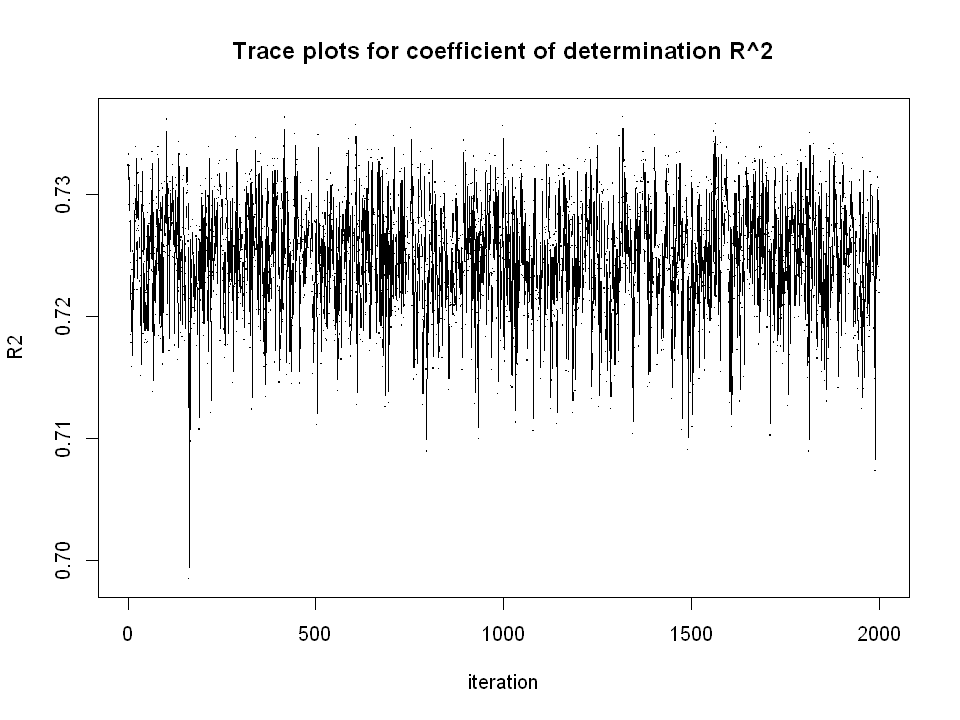

In [28]:
# check traceplot of coefficient of determination
plot(1:B, R2_MCMC, type = "b", pch = ".", xlab = "iteration",  ylab = "R2",
     main = paste0("Trace plots for coefficient of determination R^2"))

# Random-weighting (One-step procedure)

$$
\widehat{\boldsymbol{\beta}}_n^w 
= {\rm arg\,min}_{\boldsymbol{\beta}}
\left\{
\sum_{i=1}^n  W_i ( y_i - \boldsymbol{x}_i' \boldsymbol{\beta} )^2 
+ \lambda_n \sum_{j=1}^{p_n} W_{0,j} |\beta_j|
\right\},
$$
where $W_i \stackrel{iid}{\sim} Exp(1)$, and

* weighting scheme 1: $W_{0,j} = 1$ $\forall$ $j$ 
* weighting scheme 2: $W_{0,j} = W_0 \sim Exp(1)$ 
* weighting scheme 3: $W_{0,j} \stackrel{iid}{\sim} Exp(1)$ 

First determine the value of $\lambda$ by cross validation on unweighted/standard Lasso procedure.Then repeatedly draw weights and optimize the weighted Lasso objective function.

In [8]:
# # first get lambda
# res0 = cv.glmnet(x = X_train, y = Y_train); plot(res0)
# lamb = res0$lambda.min

# beta_RW1 <- matrix(NA, nrow = B, ncol = p) # no penalty weight
# beta_RW2 <- matrix(NA, nrow = B, ncol = p) # common penalty weight
# beta_RW3 <- matrix(NA, nrow = B, ncol = p) # different penalty weights
# colnames(beta_RW1) <- var_name
# colnames(beta_RW2) <- var_name
# colnames(beta_RW3) <- var_name

# set.seed(1)

# # 1-step
# for(b in 1:B){
#   w = rexp(n_train)
#   wp = rexp(p)
#   RW1_fit = glmnet(x = X_train, y = Y_train, weights = w)
#   RW3_fit = glmnet(x = X_train, y = Y_train, weights = w, penalty.factor = wp)
  
#   beta_RW1[b,] <- as.vector(coef(RW1_fit, s = lamb))[-1]
#   beta_RW2[b,] <- as.vector(coef(RW1_fit, s = lamb*wp[1]))[-1]
#   beta_RW3[b,] <- as.vector(coef(RW3_fit, s = lamb*mean(wp)))[-1]
  
#   if(b %% 100 == 0){
#     print(b)
#   }
# }

# save(lamb, beta_RW1, beta_RW2, beta_RW3, file = "Boston_RW_onestep.RData")
load("Boston_RW_onestep.RData")

# probability of variables being selected
select_RW1 <- apply(beta_RW1, 2, function(x){
  1 - sum(as.numeric(x == 0))/B})
select_RW2 <- apply(beta_RW2, 2, function(x){
  1 - sum(as.numeric(x == 0))/B})
select_RW3 <- apply(beta_RW3, 2, function(x){
  1 - sum(as.numeric(x == 0))/B})

# SSE
SSE_RW1 <- apply(beta_RW1 , 1, function(b){
  sum( (Y_train - X_train %*% b)^2 )
})
SSE_RW2 <- apply(beta_RW2 , 1, function(b){
  sum( (Y_train - X_train %*% b)^2 )
})
SSE_RW3 <- apply(beta_RW3 , 1, function(b){
  sum( (Y_train - X_train %*% b)^2 )
})

# R^2
R2_RW1 <- 1 - SSE_RW1/SSTO_train
R2_RW2 <- 1 - SSE_RW2/SSTO_train
R2_RW3 <- 1 - SSE_RW3/SSTO_train

# MSPE
MSPE_RW1 <- apply(beta_RW1, 1, function(b){
  mean( (Y_test - X_test %*% b)^2 )
})
MSPE_RW2 <- apply(beta_RW2, 1, function(b){
  mean( (Y_test - X_test %*% b)^2 )
})
MSPE_RW3 <- apply(beta_RW3, 1, function(b){
  mean( (Y_test - X_test %*% b)^2 )
})

In [7]:
# CV-selected lambda
lamb

[1] 0.001740866

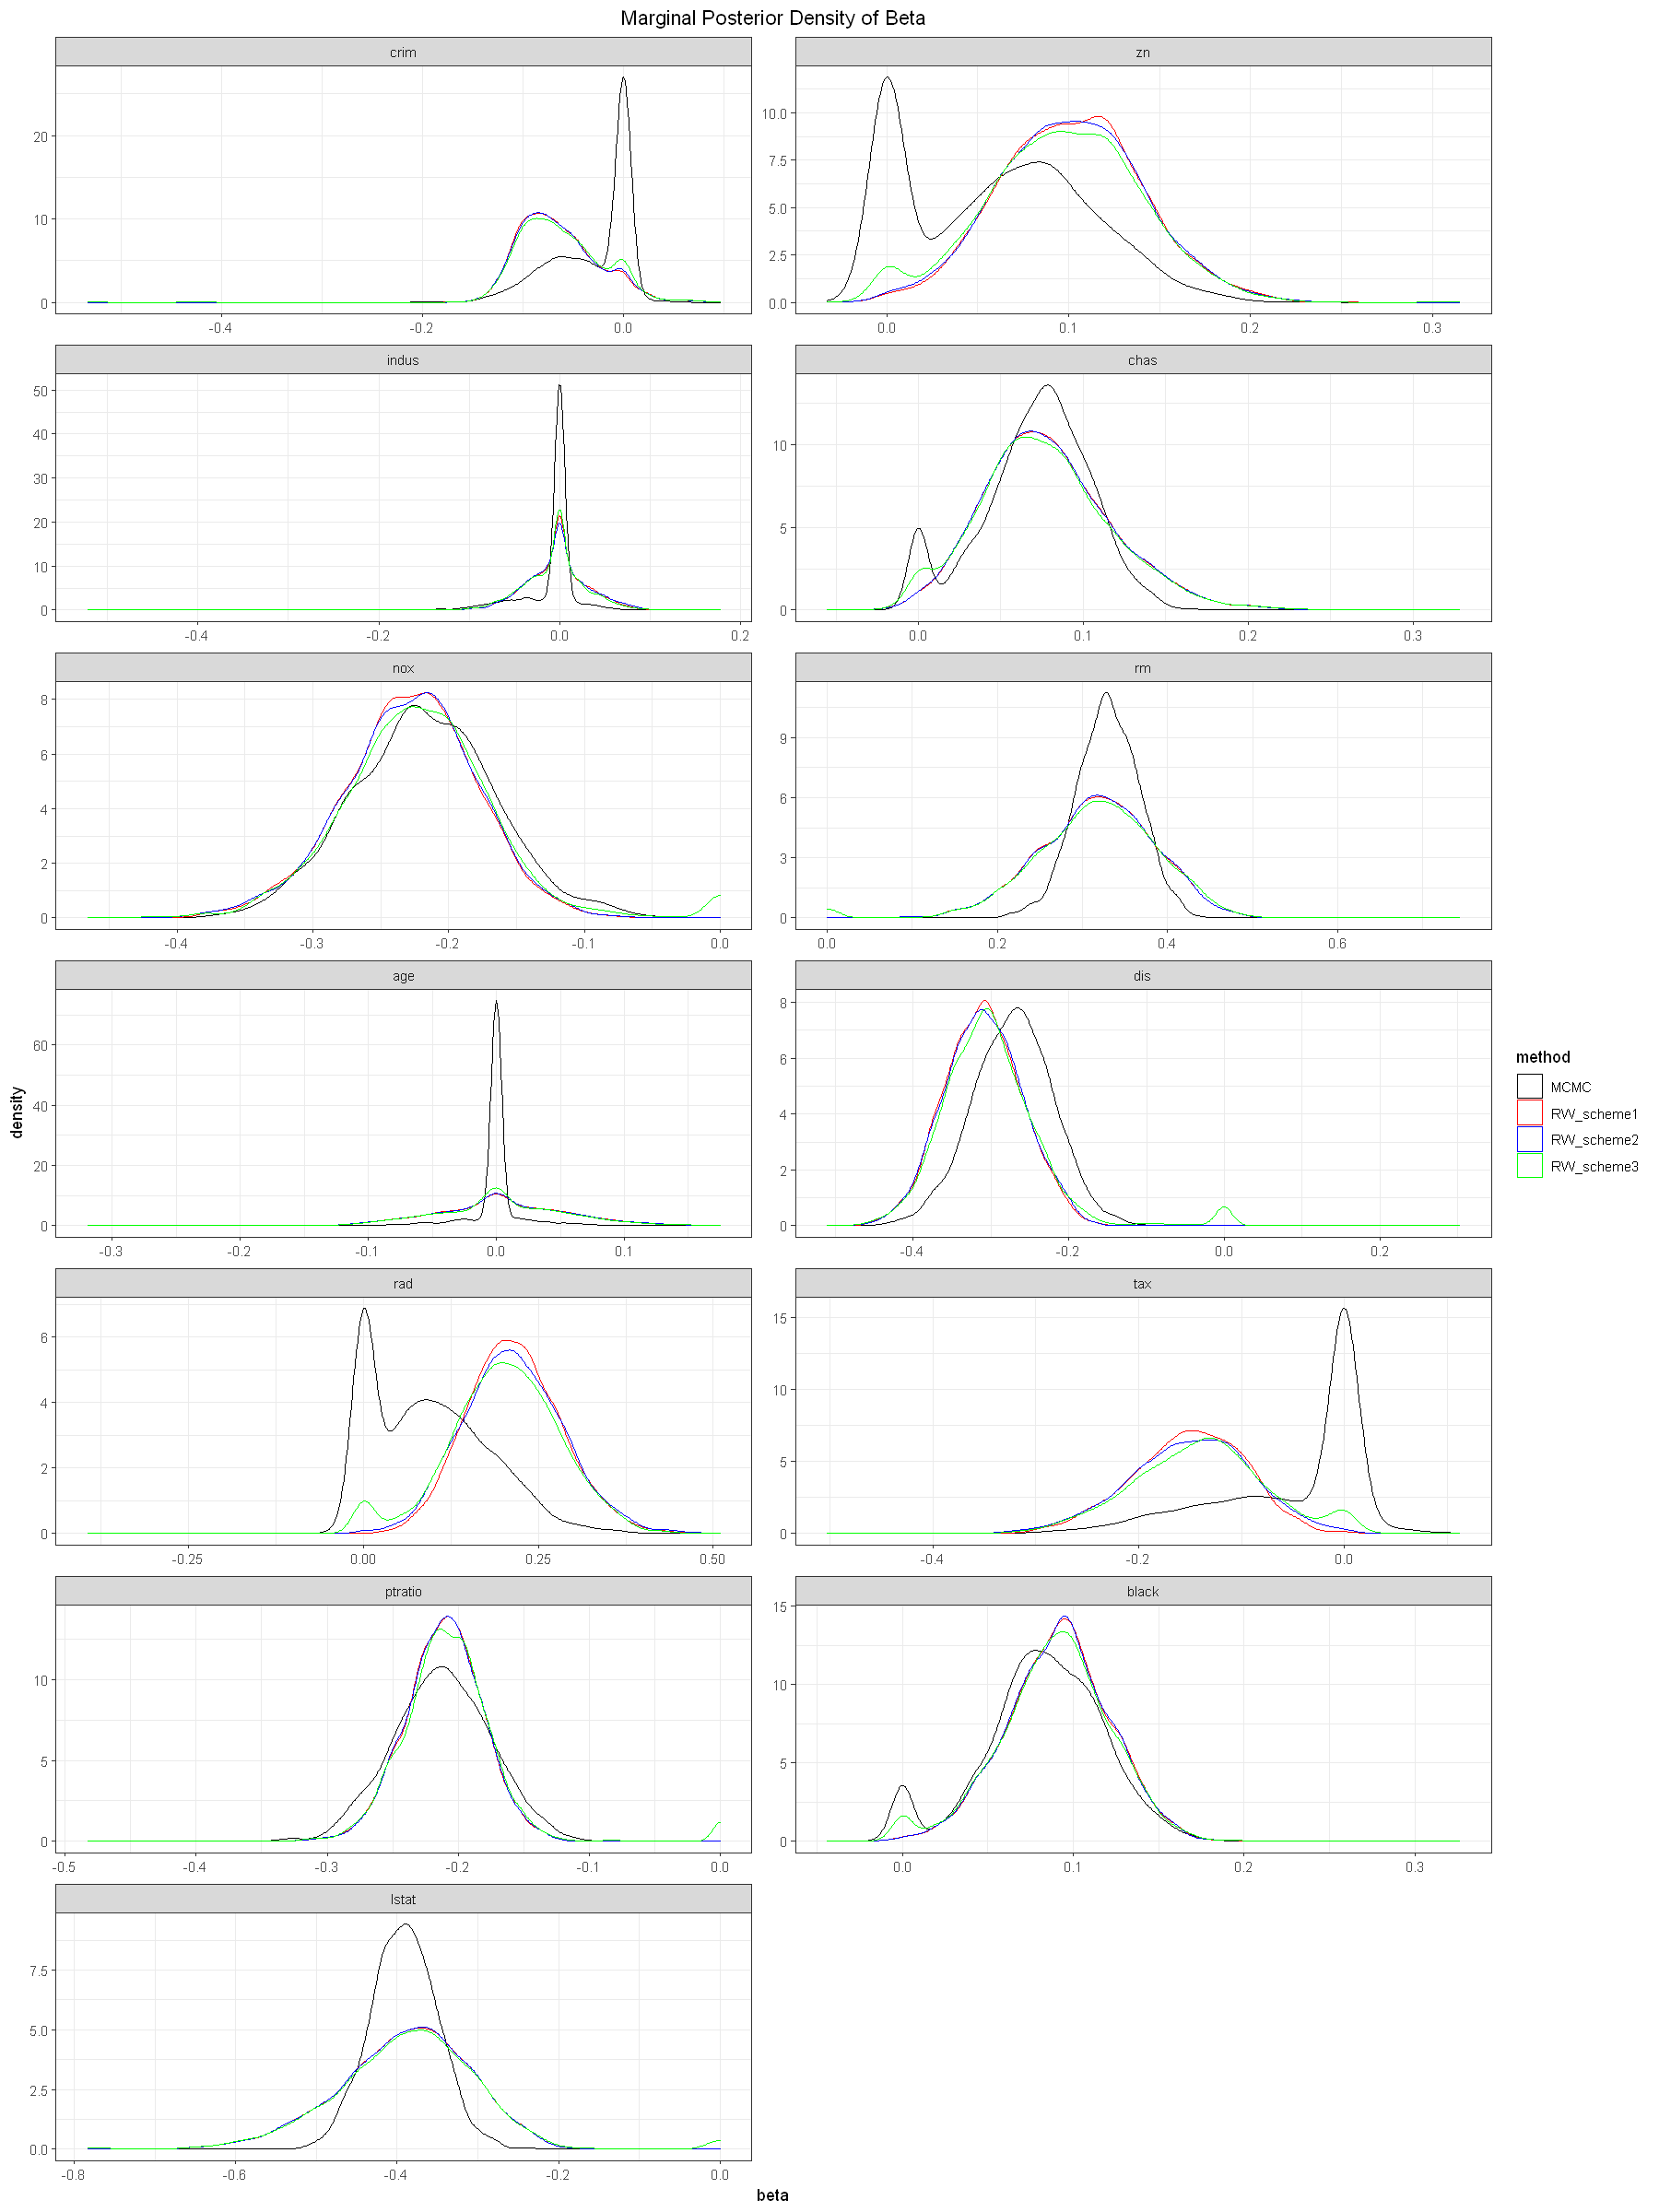

In [15]:
# compare marginal posterior density of beta
options(repr.plot.width = 15, repr.plot.height = 20)

pos_dens_beta(
  beta_MCMC = beta_MCMC, 
  beta_RW1 = beta_RW1, 
  beta_RW2 = beta_RW2, 
  beta_RW3 = beta_RW3, 
  title = "Marginal Posterior Density of Beta"
)

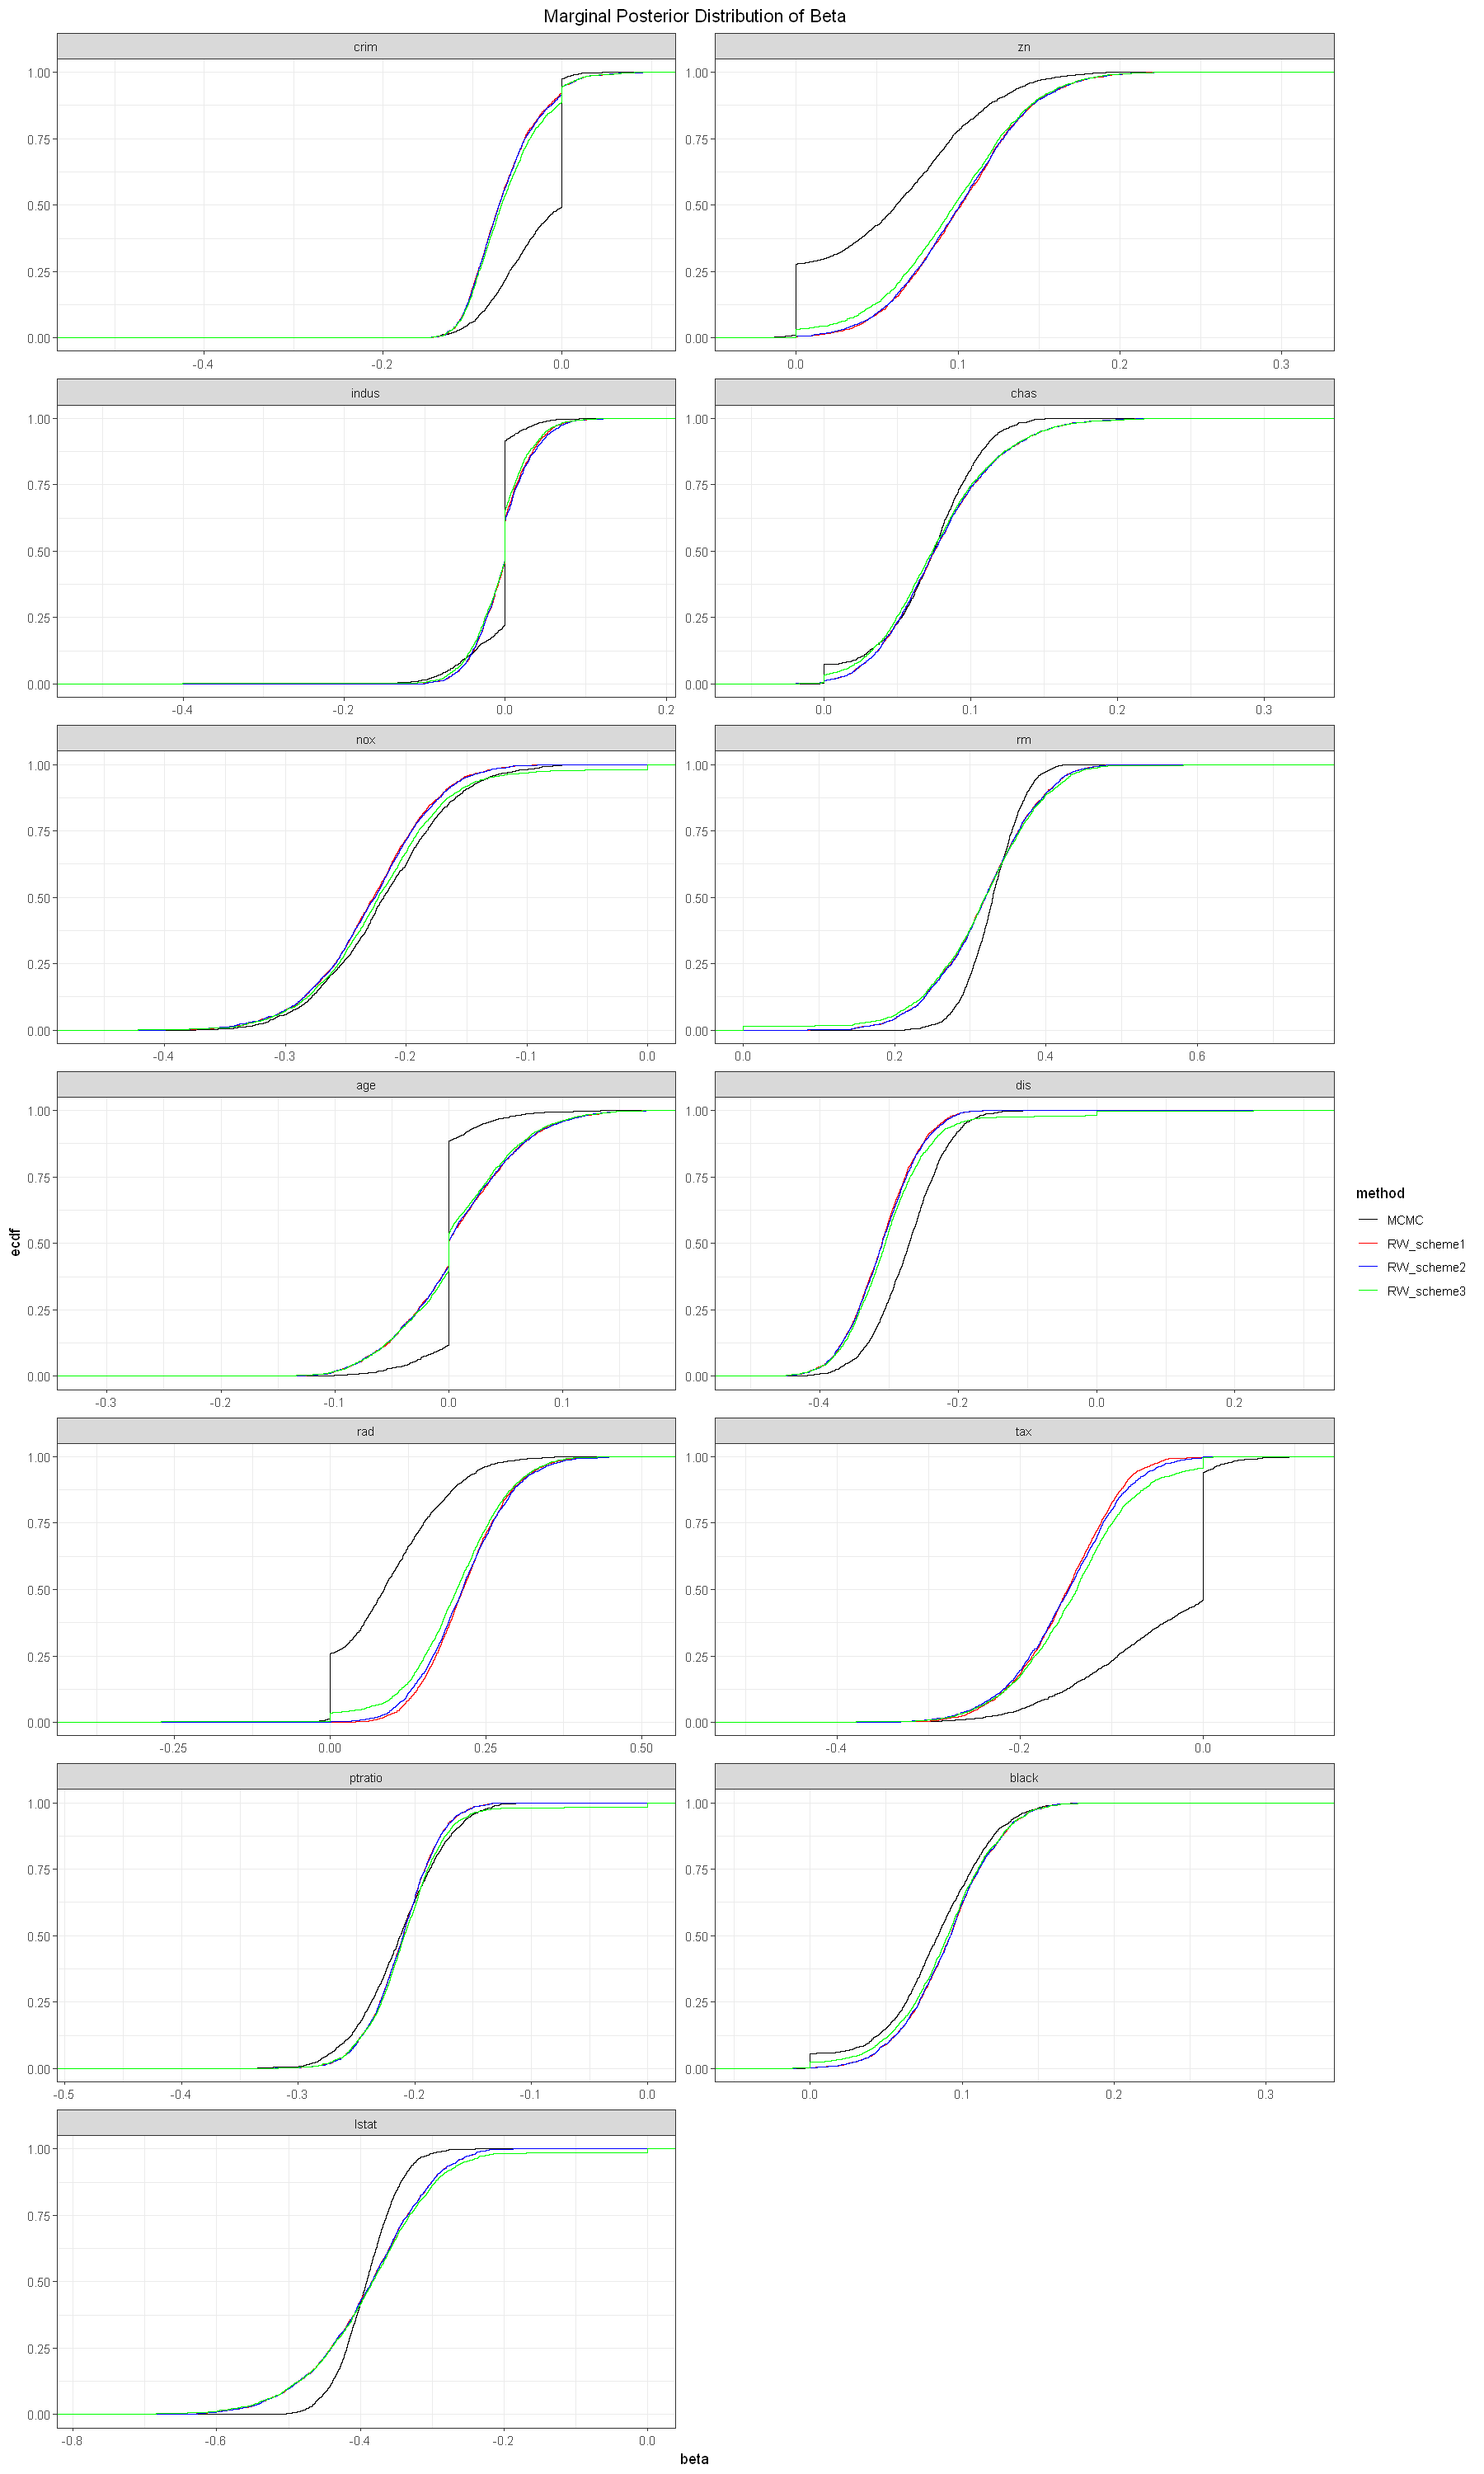

In [17]:
options(repr.plot.width = 15, repr.plot.height = 25)

# compare marginal posterior cdf of beta
pos_cdf_beta(
  beta_MCMC = beta_MCMC, 
  beta_RW1 = beta_RW1, 
  beta_RW2 = beta_RW2, 
  beta_RW3 = beta_RW3, 
  title = "Marginal Posterior Distribution of Beta"
)

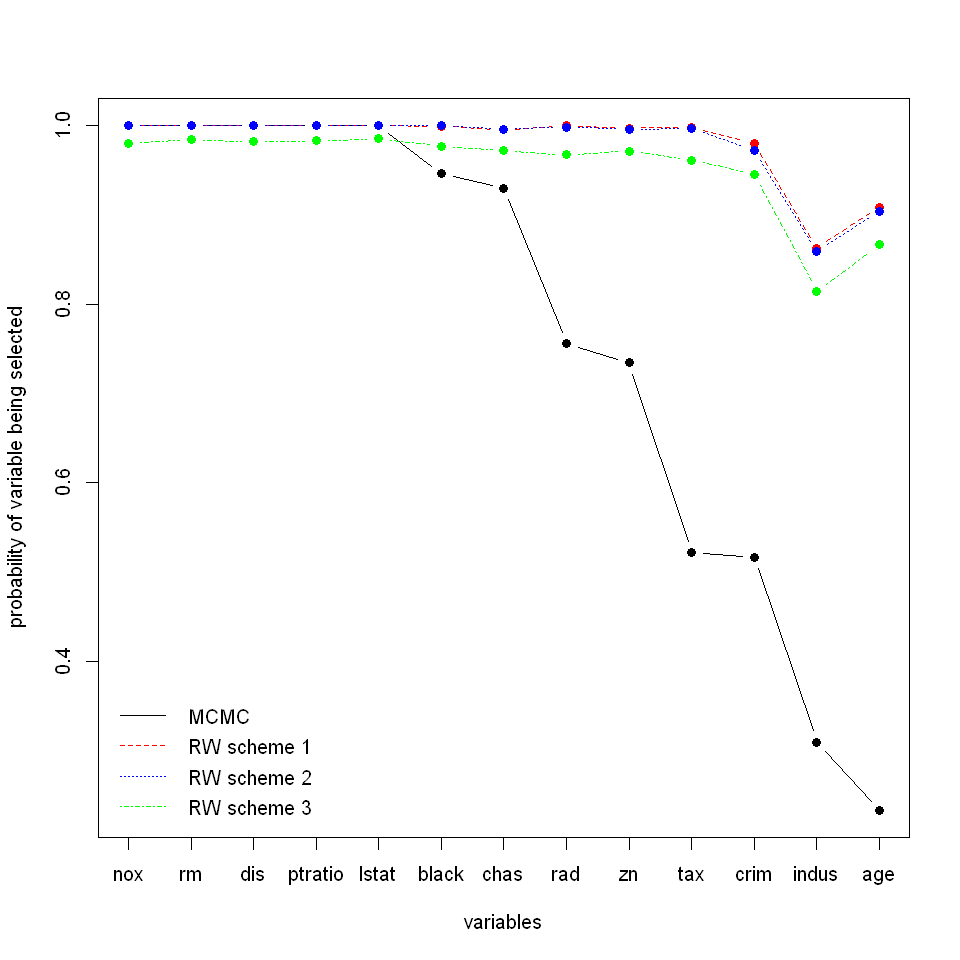

In [20]:
options(repr.plot.width = 8, repr.plot.height = 8)

# probability of variables being selected
plot_prob_var_select(
  select_MCMC = select_MCMC, 
  select_RW1 = select_RW1, 
  select_RW2 = select_RW2, 
  select_RW3 = select_RW3
)

Warning message:
"Removed 39 rows containing non-finite values (stat_density)."


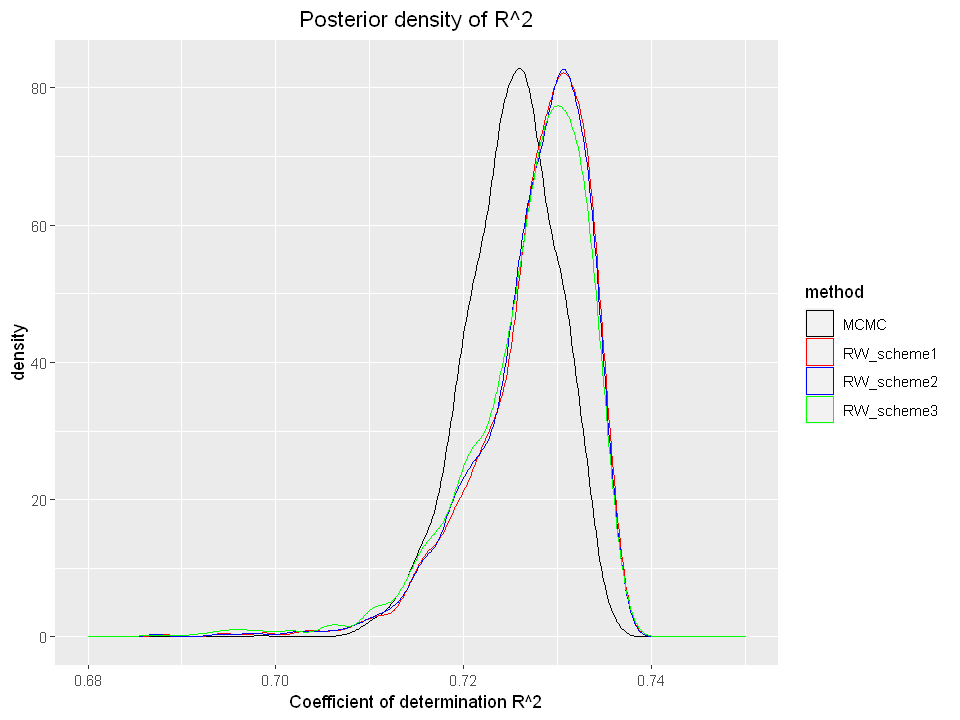

In [24]:
options(repr.plot.width = 8, repr.plot.height = 6)
# compare density of R^2
dens_plot.func(
  MCMC_vec = R2_MCMC, 
  RW1_vec = R2_RW1, 
  RW2_vec = R2_RW2, 
  RW3_vec = R2_RW3, 
  xlab = "Coefficient of determination R^2", 
  title = "Posterior density of R^2", 
  plot_type = "density"
) + xlim(.68,.75)

Warning message:
"Removed 39 rows containing non-finite values (stat_ecdf)."


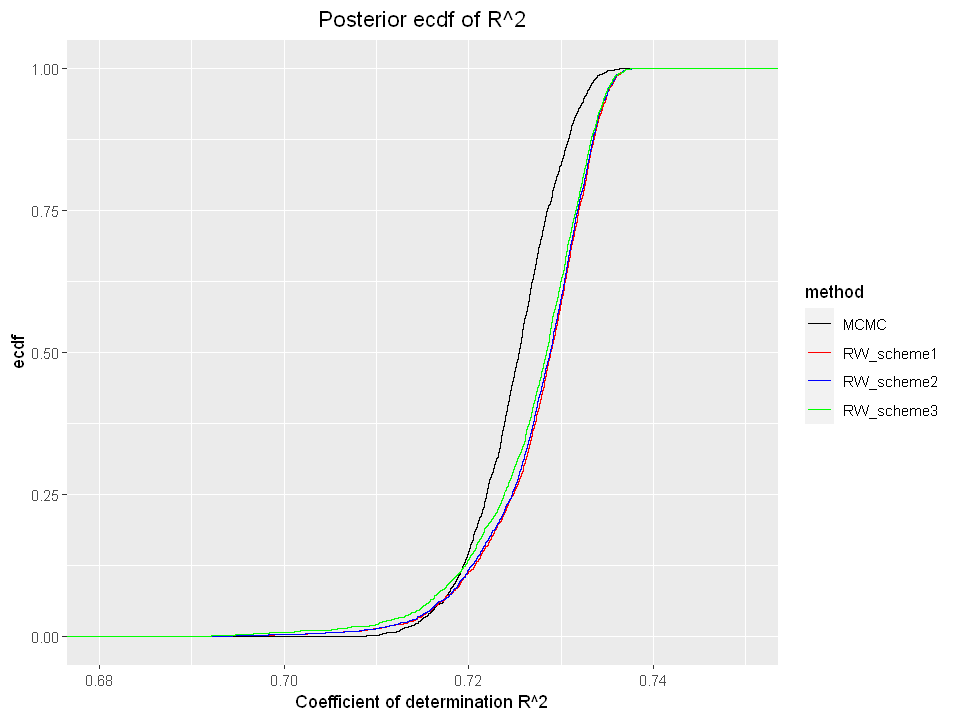

In [25]:
options(repr.plot.width = 8, repr.plot.height = 6)

# compare ecdf of R^2
dens_plot.func(
  MCMC_vec = R2_MCMC, 
  RW1_vec = R2_RW1, 
  RW2_vec = R2_RW2, 
  RW3_vec = R2_RW3, 
  xlab = "Coefficient of determination R^2", 
  title = "Posterior ecdf of R^2", 
  plot_type = "ecdf"
) + xlim(.68,.75)

Warning message:
"Removed 39 rows containing non-finite values (stat_density)."


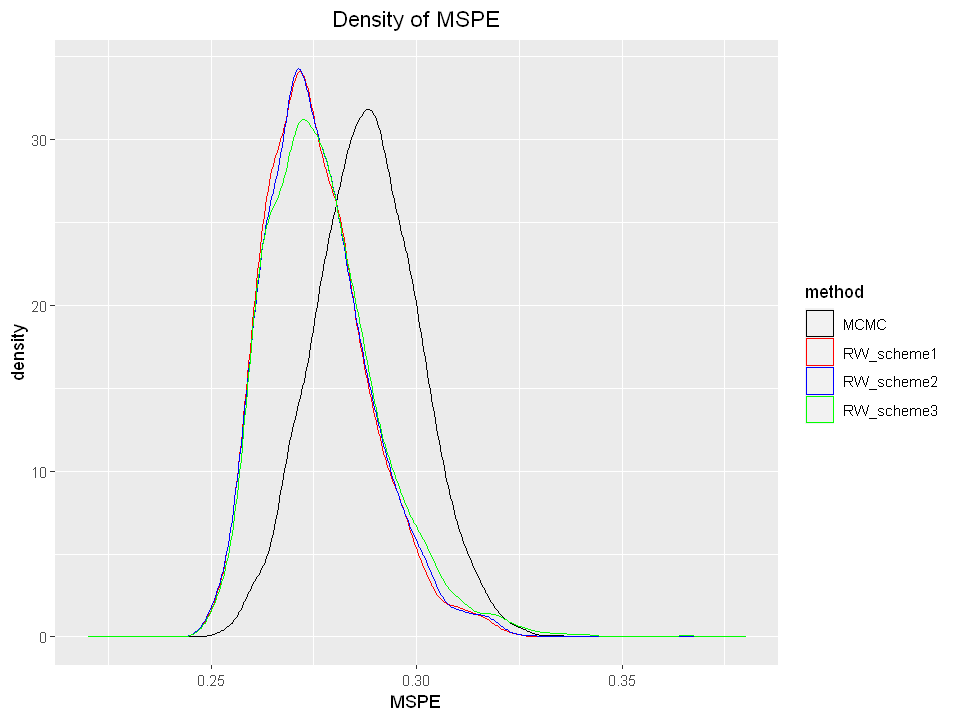

In [29]:
options(repr.plot.width = 8, repr.plot.height = 6)

# compare density of MSPE
dens_plot.func(
  MCMC_vec = MSPE_MCMC, 
  RW1_vec = MSPE_RW1, 
  RW2_vec = MSPE_RW2, 
  RW3_vec = MSPE_RW3, 
  xlab = "MSPE", 
  title = "Density of MSPE", 
  plot_type = "density"
) + xlim(.22,.38)

Warning message:
"Removed 40 rows containing non-finite values (stat_ecdf)."


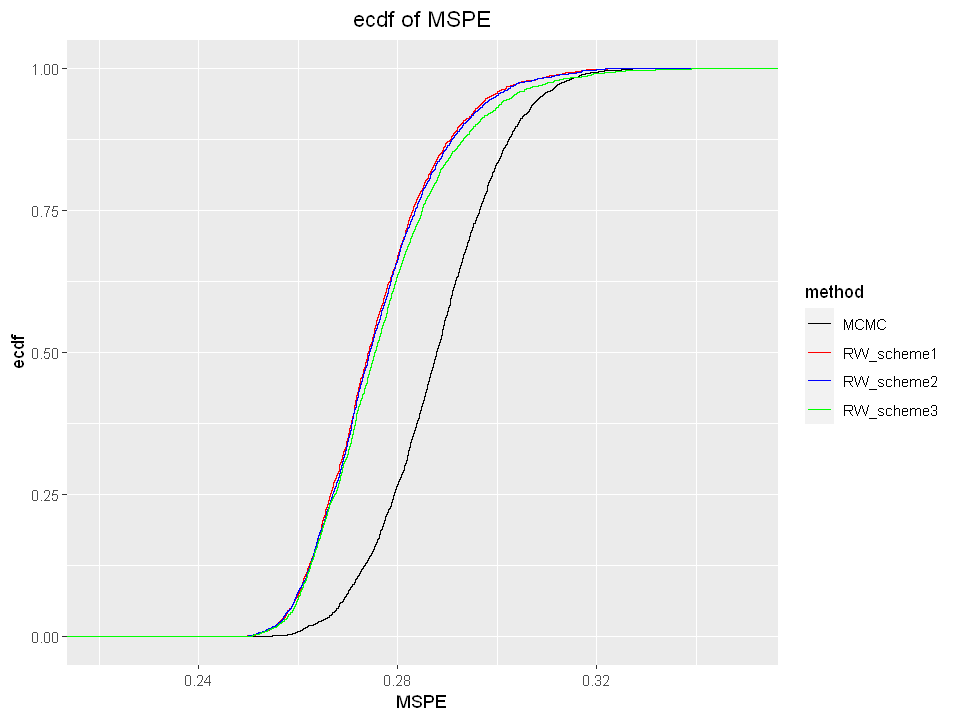

In [30]:
# compare ecdf of MSPE
dens_plot.func(
  MCMC_vec = MSPE_MCMC, 
  RW1_vec = MSPE_RW1, 
  RW2_vec = MSPE_RW2, 
  RW3_vec = MSPE_RW3, 
  xlab = "MSPE", 
  title = "ecdf of MSPE", 
  plot_type = "ecdf"
) + xlim(.22,.35)


# Random-weighting (Two-step procedure)

First determine the value of $\lambda$ by cross validation on unweighted two-step Lasso+LS procedure.Then repeatedly draw weights and perform a two-step optimization in the following manner:

**First step**: optimize the following to select variables  
$$
\min_{\boldsymbol{\beta}}
\left\{
\sum_{i=1}^n  W_i ( y_i - \boldsymbol{x}_i' \boldsymbol{\beta} )^2 
+ \lambda_n \sum_{j=1}^{p_n} W_{0,j} |\beta_j|
\right\},
$$
where $W_i \stackrel{iid}{\sim} Exp(1)$, and

* weighting scheme 1: $W_{0,j} = 1$ $\forall$ $j$ 
* weighting scheme 2: $W_{0,j} = W_0 \sim Exp(1)$ 
* weighting scheme 3: $W_{0,j} \stackrel{iid}{\sim} Exp(1)$ 

Denote $\widehat{S}^w_n \subseteq \{1, \cdots, p_n\}$ as the set of selected variables from step 1. Then, 

**Second step**: obtain
$$
\widehat{\boldsymbol{\beta}}_n^w
= \left( 
    X'_{\widehat{S}^w_n} D_n X_{\widehat{S}^w_n}
\right)^{-1}
 X'_{\widehat{S}^w_n} D_n Y,
$$
where $D_n = (W_1, \cdots, W_n)$. 

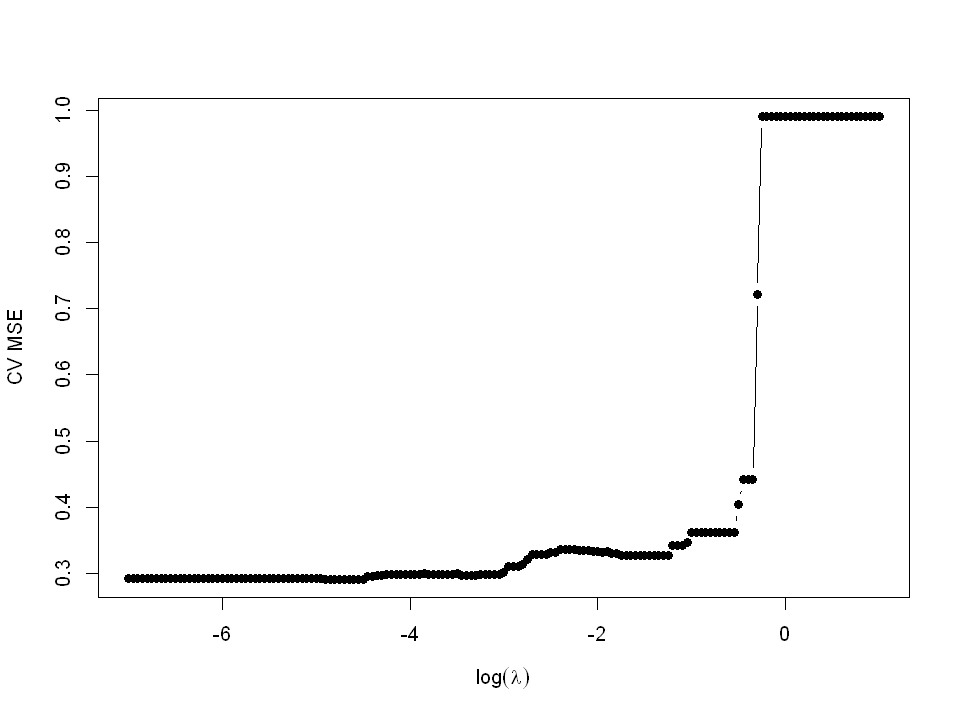

In [33]:
# my own cv step

# grid for log-lambdas
loglamb_vec <- seq(-7, 1, by = .05) 

# initiate cv MSE
cv_MSE <- rep(NA, length(loglamb_vec))

# K-fold cv
cv_K <- 4

# cv partition
part_count <- rep(floor(n_train/cv_K), cv_K)
part_count[cv_K] <- n_train - sum(head(part_count,-1)) 
cv_part <- rep(1:cv_K, times = part_count)
cv_part <- sample(cv_part, size = n_train, replace = F)

# compute CV MSE  
for(l in 1:length(loglamb_vec)){
  loglamb <- loglamb_vec[l]
  lamb <- exp(loglamb)
  cv_SSE <- 0
  
  for(k in 1:cv_K){
    Y_cvTrain <- scale(Y_train[(cv_part != k)])
    X_cvTrain <- scale(X_train[(cv_part != k),])
    Y_cvTest <- scale(Y_train[(cv_part == k)])
    X_cvTest <- scale(X_train[(cv_part == k),])
    
    cvfit = glmnet(x = X_cvTrain, y = Y_cvTrain)
    beta_cvfit = as.vector(coef(cvfit, s = lamb))[-1]
    if( sum(abs(beta_cvfit)) != 0 ){
      nonzero_cvfit <- as.vector( which(beta_cvfit != 0) )
      beta_cvfit[nonzero_cvfit] <- as.vector(coef(lm(Y_cvTrain ~ X_cvTrain[, nonzero_cvfit] - 1)))
    }
    cv_SSE = cv_SSE + sum( (Y_cvTest -  X_cvTest %*%beta_cvfit)^2 )
  }
  
  cv_MSE[l] <- cv_SSE/n_train
}

# plot cv MSE
plot( loglamb_vec, cv_MSE, type = "b", pch = 16, xlab = expr(paste(log(lambda))), ylab =  "CV MSE")

In [35]:
# 2-step

# lamb <- lamb.min
# 
# beta_RW1 <- matrix(NA, nrow = B, ncol = p) # no penalty weight
# beta_RW2 <- matrix(NA, nrow = B, ncol = p) # common penalty weight
# beta_RW3 <- matrix(NA, nrow = B, ncol = p) # different penalty weights
# colnames(beta_RW1) <- var_name
# colnames(beta_RW2) <- var_name
# colnames(beta_RW3) <- var_name
# 
# set.seed(1)
# for(b in 1:B){
#   w = rexp(n_train)
#   wp = rexp(p)
#   RW1_fit = glmnet(x = X_train, y = Y_train, weights = w)
#   RW3_fit = glmnet(x = X_train, y = Y_train, weights = w, penalty.factor = wp)
#   
#   beta_RW1[b,] <- as.vector(coef(RW1_fit, s = lamb))[-1]
#   beta_RW2[b,] <- as.vector(coef(RW1_fit, s = lamb*wp[1]))[-1]
#   beta_RW3[b,] <- as.vector(coef(RW3_fit, s = lamb*mean(wp)))[-1]
#   
#   nonzero_RW1 <- as.vector( which(beta_RW1[b,] != 0) )
#   nonzero_RW2 <- as.vector( which(beta_RW2[b,] != 0) )
#   nonzero_RW3 <- as.vector( which(beta_RW3[b,] != 0) ) 
#   
#   beta_RW1[b, nonzero_RW1] <- as.vector(coef(lm(Y_train ~ X_train[, nonzero_RW1] - 1, weights = w)))
#   beta_RW2[b, nonzero_RW2] <- as.vector(coef(lm(Y_train ~ X_train[, nonzero_RW2] - 1, weights = w)))
#   beta_RW3[b, nonzero_RW3] <- as.vector(coef(lm(Y_train ~ X_train[, nonzero_RW3] - 1, weights = w)))
#   
#   if(b %% 100 == 0){
#     print(b)
#   }
# }
# 
# save(lamb, beta_RW1, beta_RW2, beta_RW3, file = "Boston_RW_twostep.RData")
load("Boston_RW_twostep.RData") 

lamb

[1] 0.008651695

In [36]:
# probability of variables being selected
select_RW1 <- apply(beta_RW1, 2, function(x){
  1 - sum(as.numeric(x == 0))/B})
select_RW2 <- apply(beta_RW2, 2, function(x){
  1 - sum(as.numeric(x == 0))/B})
select_RW3 <- apply(beta_RW3, 2, function(x){
  1 - sum(as.numeric(x == 0))/B})

# SSE
SSE_RW1 <- apply(beta_RW1 , 1, function(b){
  sum( (Y_train - X_train %*% b)^2 )
})
SSE_RW2 <- apply(beta_RW2 , 1, function(b){
  sum( (Y_train - X_train %*% b)^2 )
})
SSE_RW3 <- apply(beta_RW3 , 1, function(b){
  sum( (Y_train - X_train %*% b)^2 )
})

# R^2
R2_RW1 <- 1 - SSE_RW1/SSTO_train
R2_RW2 <- 1 - SSE_RW2/SSTO_train
R2_RW3 <- 1 - SSE_RW3/SSTO_train

# MSPE
MSPE_RW1 <- apply(beta_RW1, 1, function(b){
  mean( (Y_test - X_test %*% b)^2 )
})
MSPE_RW2 <- apply(beta_RW2, 1, function(b){
  mean( (Y_test - X_test %*% b)^2 )
})
MSPE_RW3 <- apply(beta_RW3, 1, function(b){
  mean( (Y_test - X_test %*% b)^2 )
})

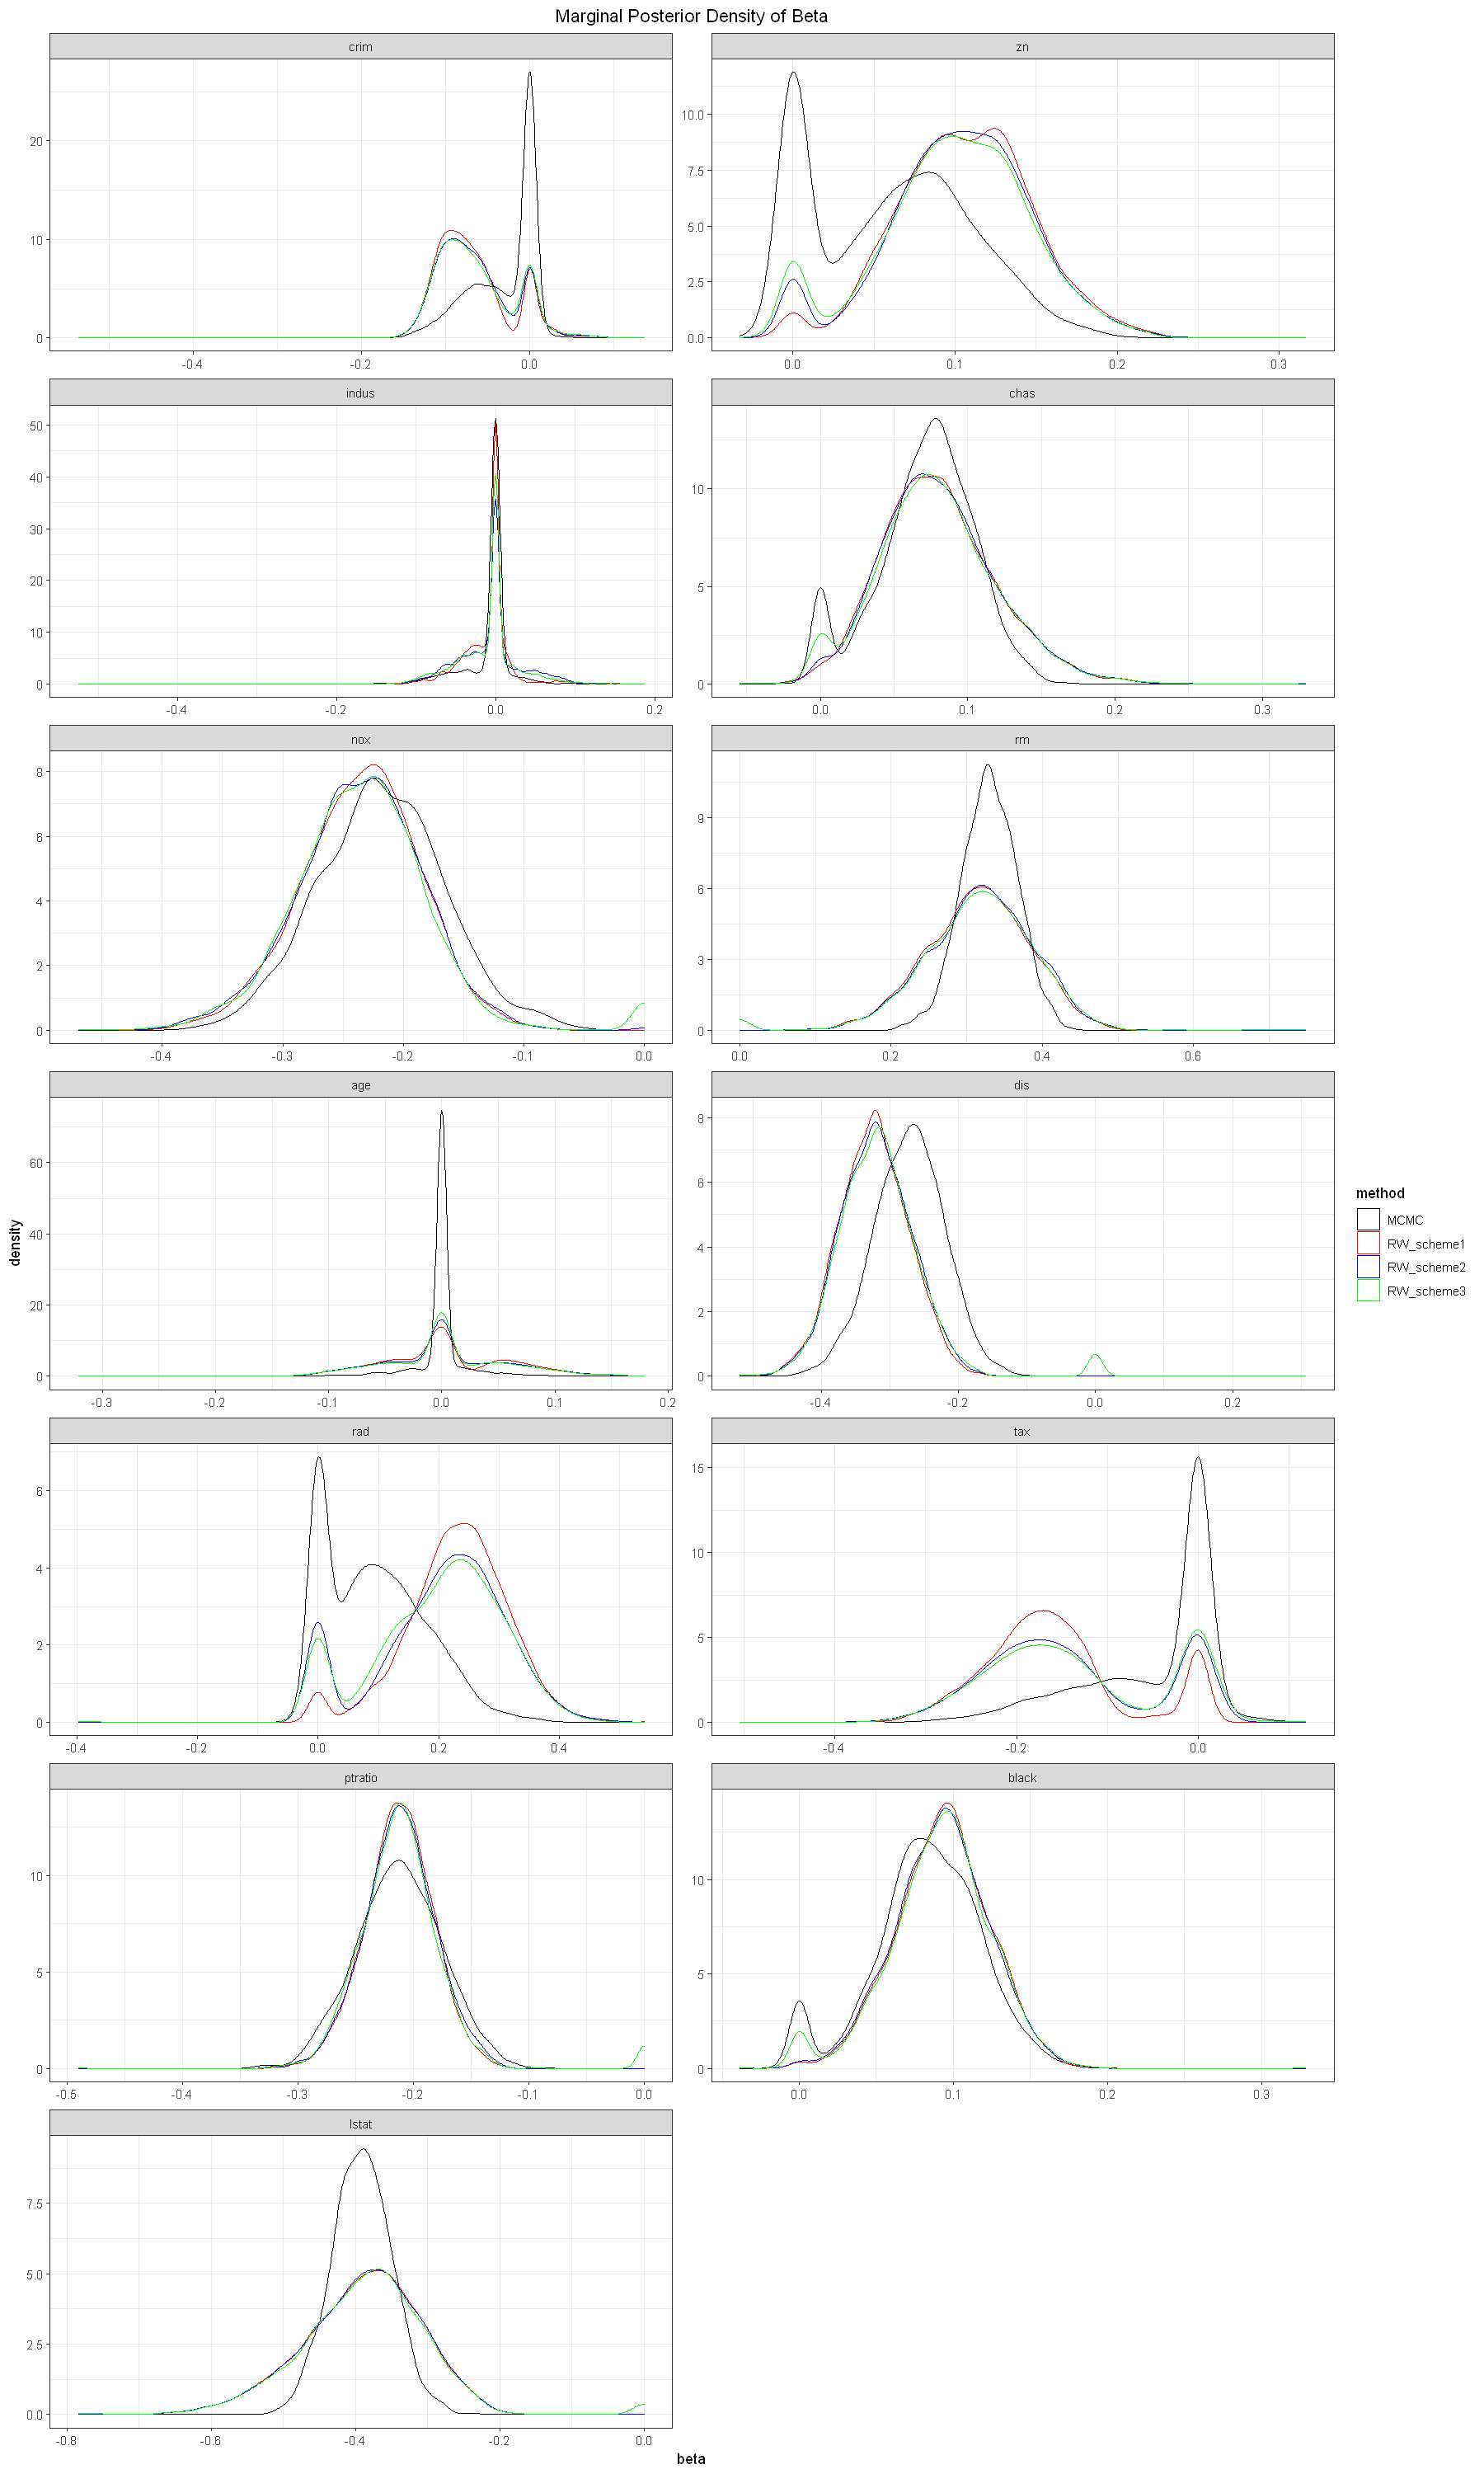

In [37]:
options(repr.plot.width = 15, repr.plot.height = 25)

# compare marginal posterior density of beta
pos_dens_beta(
  beta_MCMC = beta_MCMC, 
  beta_RW1 = beta_RW1, 
  beta_RW2 = beta_RW2, 
  beta_RW3 = beta_RW3, 
  title = "Marginal Posterior Density of Beta"
)

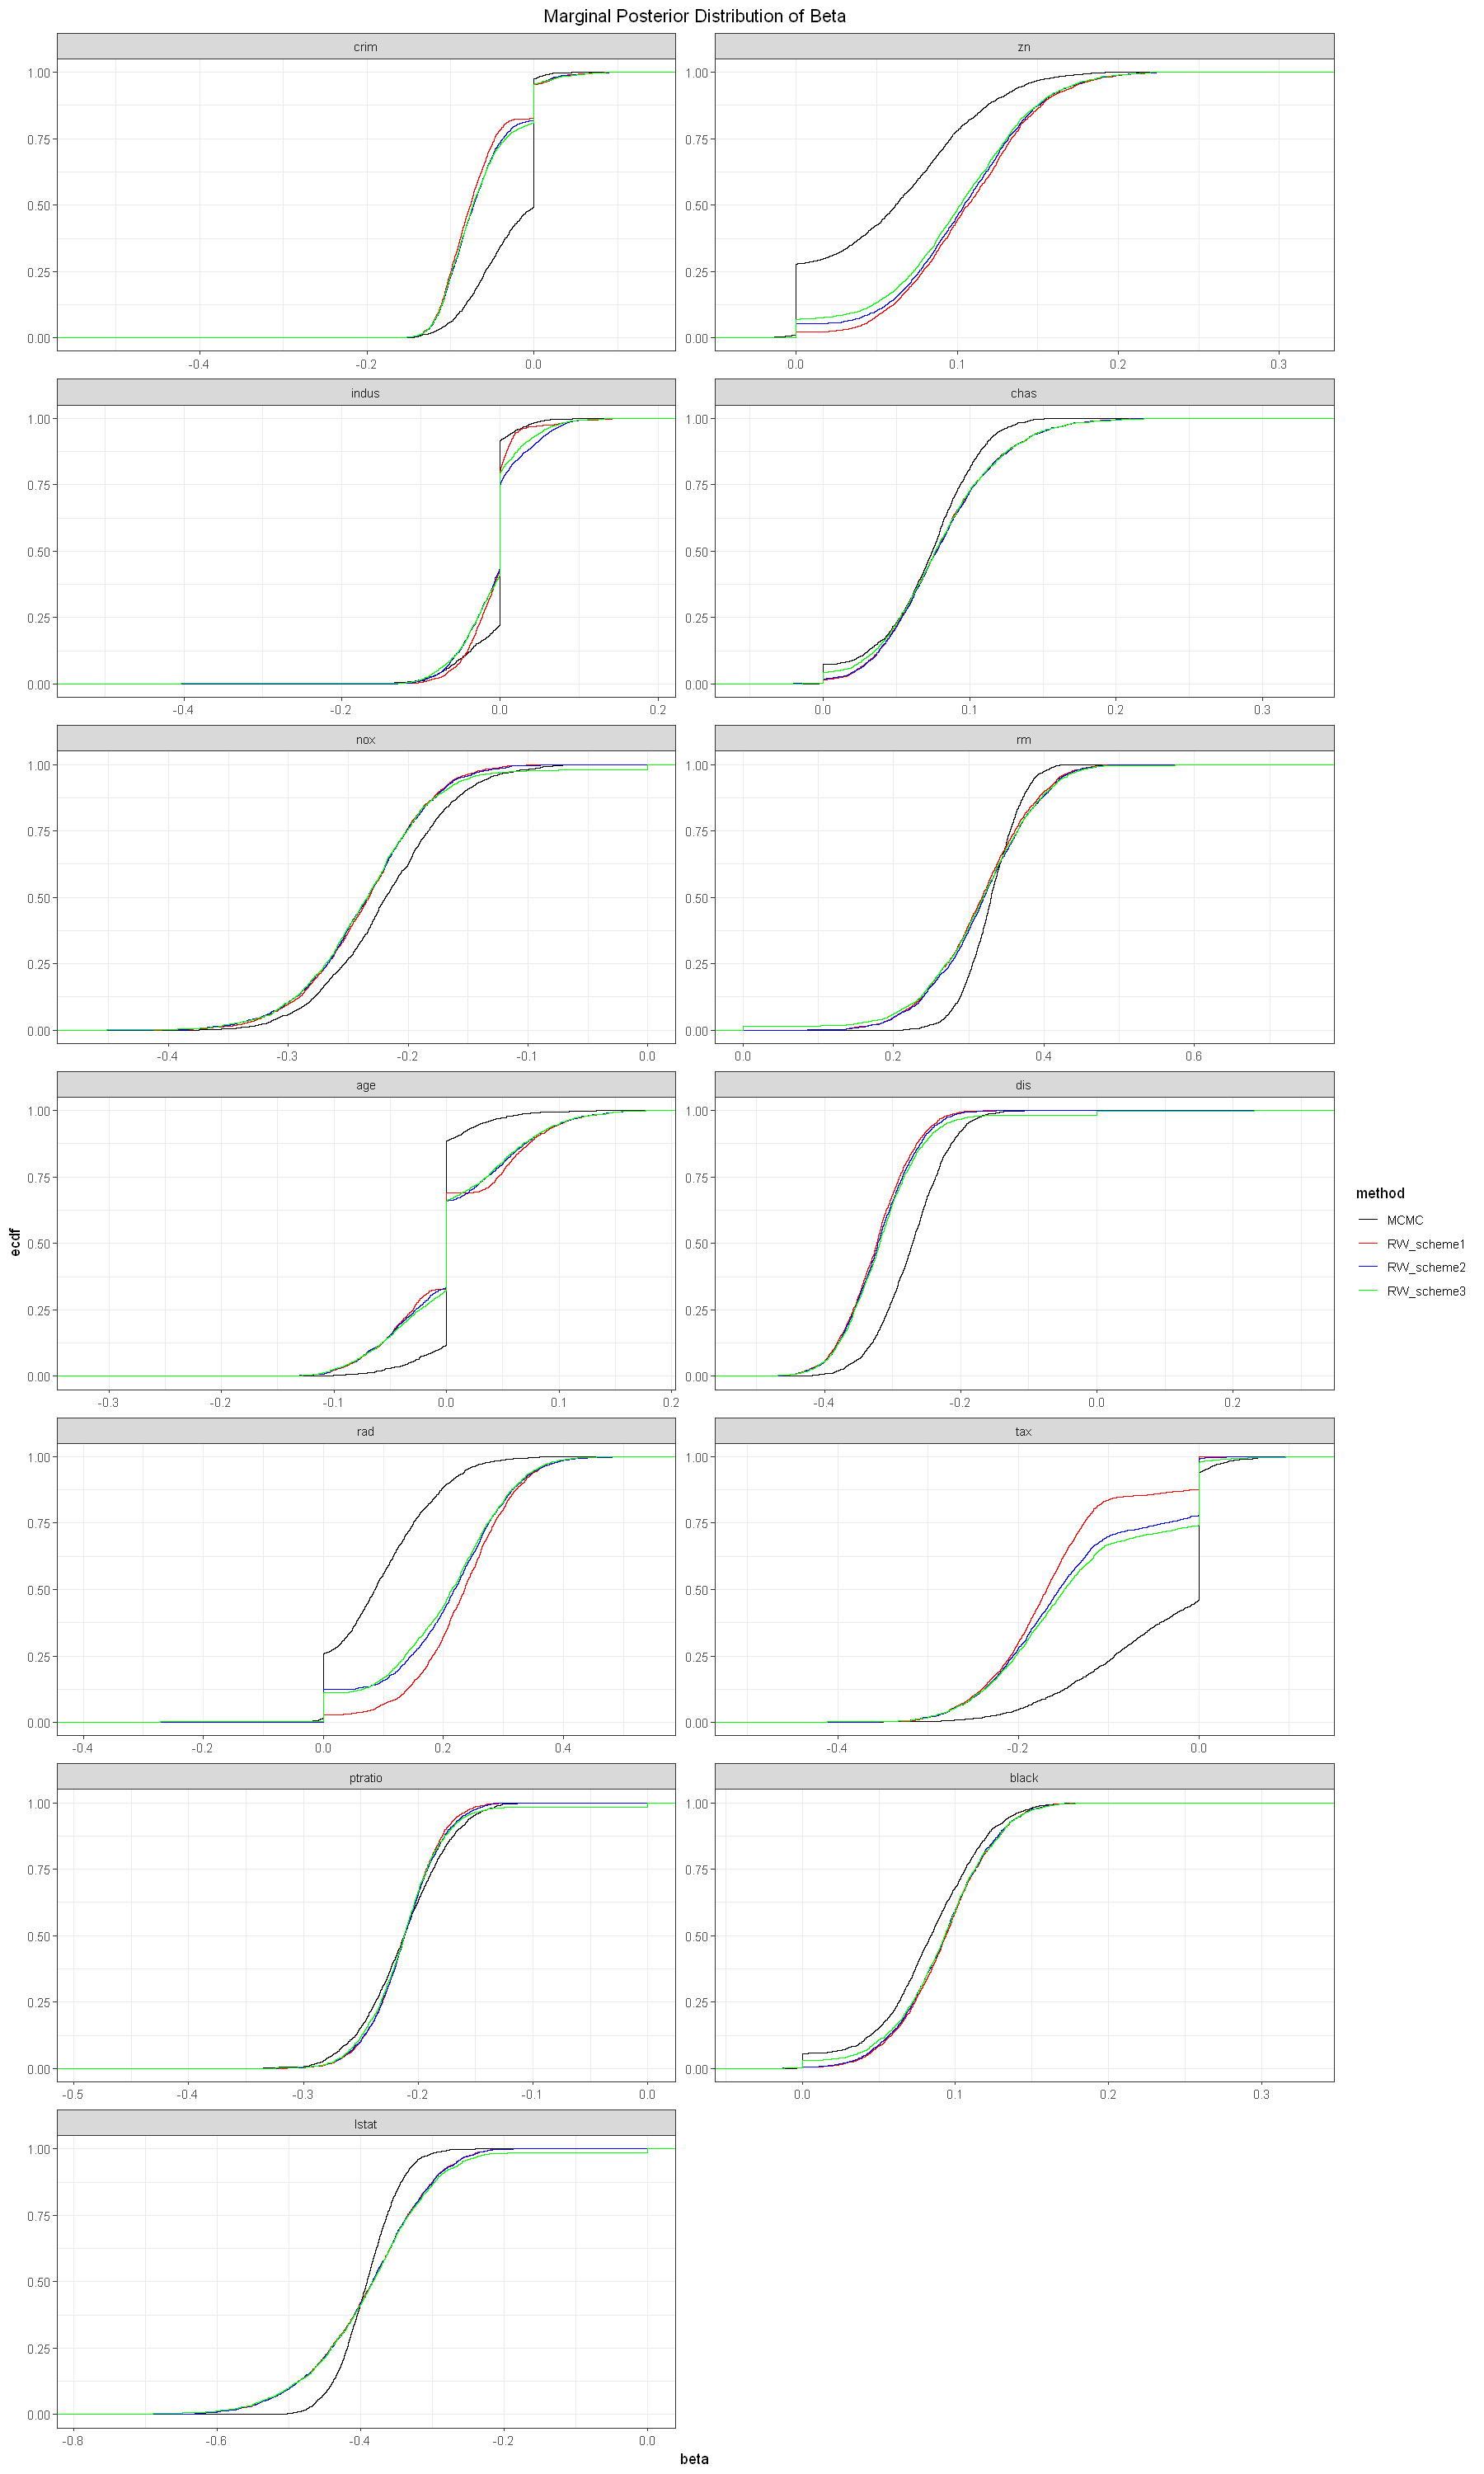

In [38]:
options(repr.plot.width = 15, repr.plot.height = 25)

# compare marginal posterior cdf of beta
pos_cdf_beta(
  beta_MCMC = beta_MCMC, 
  beta_RW1 = beta_RW1, 
  beta_RW2 = beta_RW2, 
  beta_RW3 = beta_RW3, 
  title = "Marginal Posterior Distribution of Beta"
)

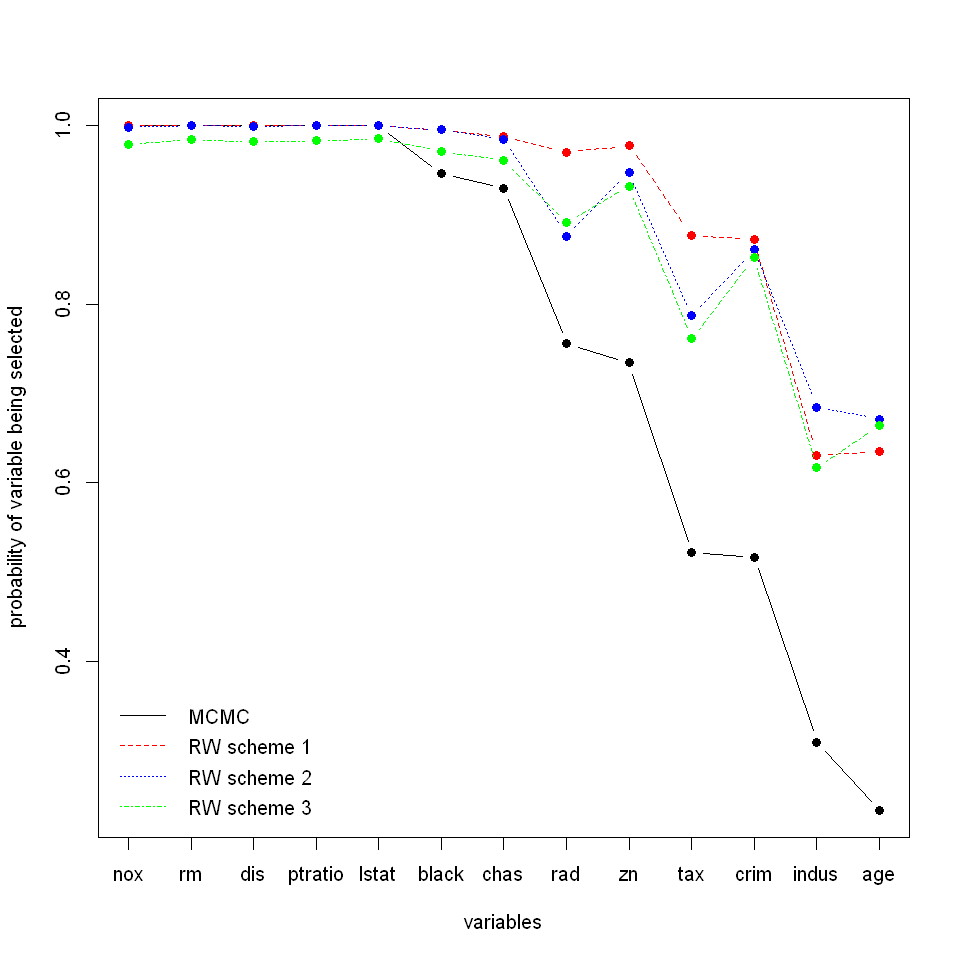

In [39]:
options(repr.plot.width = 8, repr.plot.height = 8)

# probability of variables being selected
plot_prob_var_select(
  select_MCMC = select_MCMC, 
  select_RW1 = select_RW1, 
  select_RW2 = select_RW2, 
  select_RW3 = select_RW3
)

Warning message:
"Removed 38 rows containing non-finite values (stat_density)."


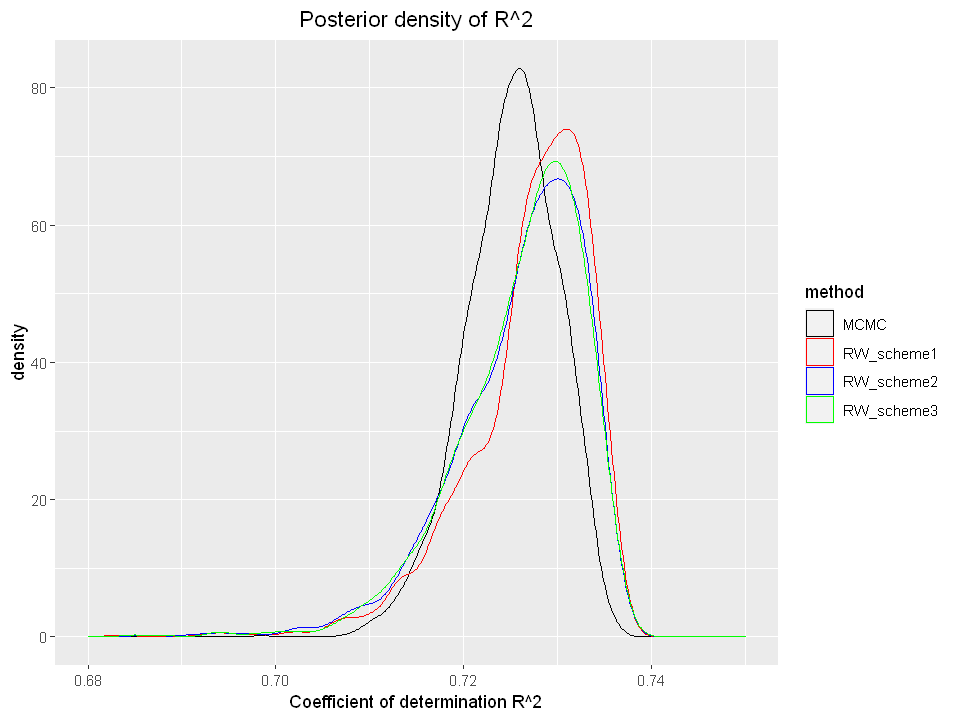

In [40]:
options(repr.plot.width = 8, repr.plot.height = 6)

# compare density of R^2
dens_plot.func(
  MCMC_vec = R2_MCMC, 
  RW1_vec = R2_RW1, 
  RW2_vec = R2_RW2, 
  RW3_vec = R2_RW3, 
  xlab = "Coefficient of determination R^2", 
  title = "Posterior density of R^2", 
  plot_type = "density"
) + xlim(.68,.75)

Warning message:
"Removed 38 rows containing non-finite values (stat_ecdf)."


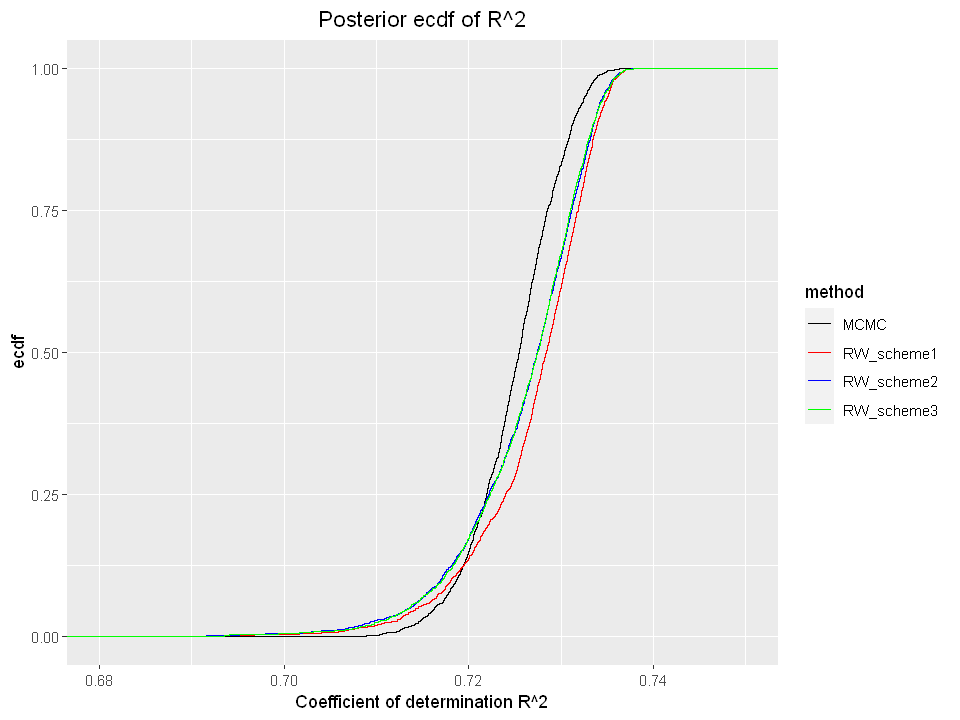

In [41]:
options(repr.plot.width = 8, repr.plot.height = 6)

# compare ecdf of R^2
dens_plot.func(
  MCMC_vec = R2_MCMC, 
  RW1_vec = R2_RW1, 
  RW2_vec = R2_RW2, 
  RW3_vec = R2_RW3, 
  xlab = "Coefficient of determination R^2", 
  title = "Posterior ecdf of R^2", 
  plot_type = "ecdf"
) + xlim(.68,.75)

Warning message:
"Removed 37 rows containing non-finite values (stat_density)."


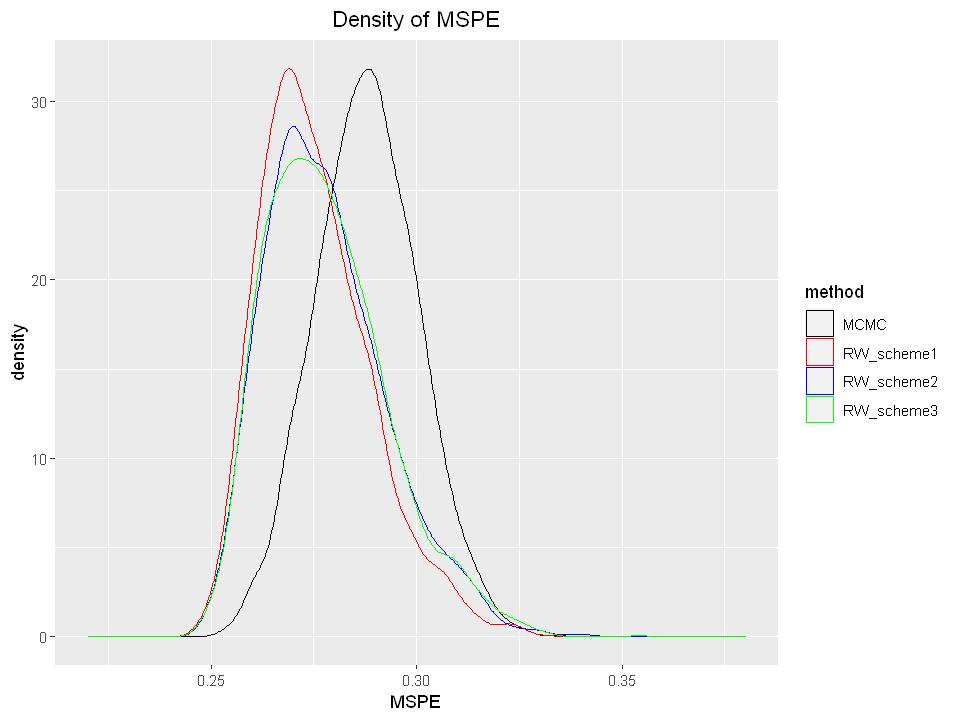

In [42]:
# compare density of MSPE
dens_plot.func(
  MCMC_vec = MSPE_MCMC, 
  RW1_vec = MSPE_RW1, 
  RW2_vec = MSPE_RW2, 
  RW3_vec = MSPE_RW3, 
  xlab = "MSPE", 
  title = "Density of MSPE", 
  plot_type = "density"
) + xlim(.22,.38)


Warning message:
"Removed 38 rows containing non-finite values (stat_ecdf)."


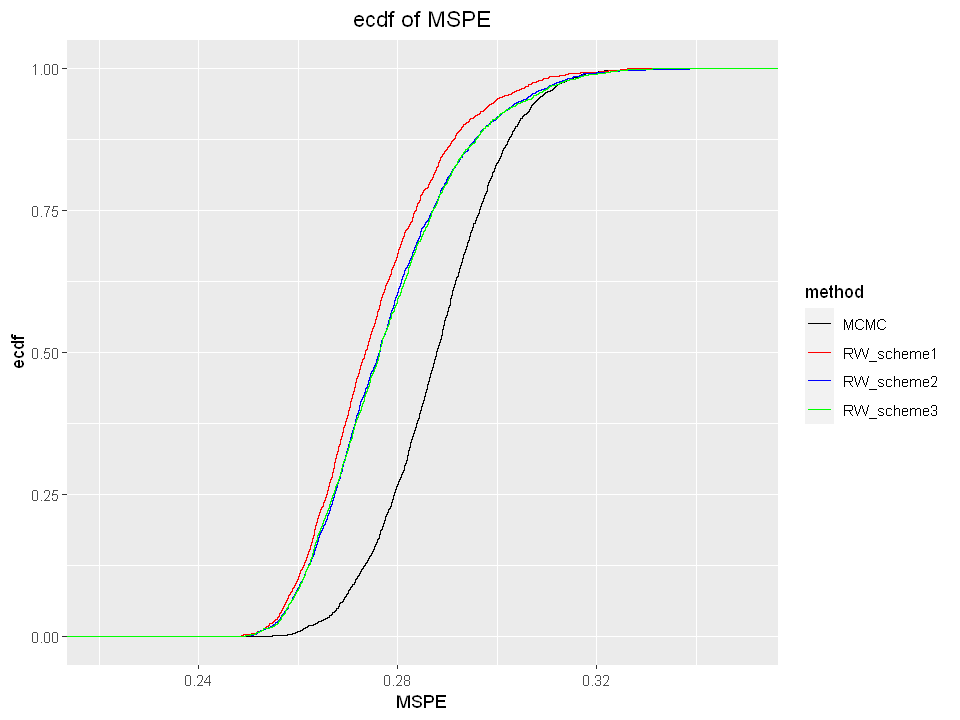

In [43]:
# compare ecdf of MSPE
dens_plot.func(
  MCMC_vec = MSPE_MCMC, 
  RW1_vec = MSPE_RW1, 
  RW2_vec = MSPE_RW2, 
  RW3_vec = MSPE_RW3, 
  xlab = "MSPE", 
  title = "ecdf of MSPE", 
  plot_type = "ecdf"
) + xlim(.22,.35)
